# Covid-19, Time To Get Out?

![alt text](man_window_covid.jpg "Title")

## Table of Contents
<ul>
<li><a href="#contact">Contact Information</a></li> 
<p>
<li><a href="#business">1. Business Understanding</a></li> 
<li style="margin-left: 40px"><a href="#q1">Q1: Who are the best and worst countries dealing with Covid-19?</a></li> 
<li style="margin-left: 40px"><a href="#q2">Q2: Which countries have flattened or are flattening the curve?</a></li>
<li style="margin-left: 40px"><a href="#q3">Q3: Can I see a global geographic representation of infections?</a></li>
<li style="margin-left: 40px"><a href="#q4">Q4: What is the projected global mortality by December 31, 2020?</a></li> 
<li style="margin-left: 40px"><a href="#q5">Q5: Number of unnecessary deaths in the 3 most poorly managed countries?</a></li> 
<p>
<li><a href="#data">2. Data Understanding</a></li> 
<li style="margin-left: 40px"><a href="#gather">Gather</a></li>
<li style="margin-left: 40px"><a href="#describe">Describe, Clean, Explore, and Verify</a></li>
<p>
<li><a href="#data_prep">3. Data Preparation</a></li> 
<li style="margin-left: 40px"><a href="#a1">Answer To Q1</a></li>    
<li style="margin-left: 40px"><a href="#a2">Answer To Q2</a></li>    
<li style="margin-left: 40px"><a href="#a3">Answer To Q3</a></li> 
<li style="margin-left: 40px"><a href="#a4">Answer To Q4</a></li>
<li style="margin-left: 40px"><a href="#a5">Answer To Q5</a></li>
<p>
<li><a href="#model">4. Model Data</a></li>
<li style="margin-left: 40px"><a href="#a4">Answer To Q4</a></li>
<p>
<li><a href="#conclusions">5. Results and Conclusions</a></li>
<li style="margin-left: 40px"><a href="#limitations">Limitations</a></li>
<p>
<li><a href="#deploy">6. Deploy</a></li>
<p>

In [137]:
# import libraries

# Regular libraries
from datetime import datetime, timedelta
import dateutil.parser
import glob
import os
from IPython.display import Image
import itertools
import json
import math
import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = (12,8)
import numpy as np
import pandas as pd
import seaborn as sns
import sys

# ARIMA libraries
from math import sqrt
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import adfuller

# There are a lot of warnings. Lets just ignore these.
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA', FutureWarning)

# Global map visualization
import plotly.express as px

# Parallel Libraries
from multiprocessing import cpu_count
from joblib import Parallel, delayed

<a id='contact'></a>
## Contact Information

> - Lindsay Moir

<a id='business'></a>
# Business Understanding

> Covid-19 is a global pandemic. We have over 150 countries affected and many approaches to the pandemic. It is possible to use data science to evaluate the leadership of countries by using mortality as a litmus test. This notebook, collects the data necessary for that, graphically shows the results for those countries, and then also runs a machine learning model to predict the total mortality by the end of 2020 (global not by country). 

<a id='q1'></a>
### Question 1

#### Who are the best and worst countries in terms of per million population and wealth dealing with Covid-19?

We will  use people per million and median income as our metrics for this. An extremely small country would have a relatively small number of deaths and could be totally incompetent at managing covid. Whereas a large country (by population) could do a great job and still have a large number of deaths. Also we have included the Transparency International ranking. Many countries are manipulating their data.

<a id='q2'></a>
### Question 2

#### Which countries have flattened or are flattening the curve?

This will be defined as the number of New_Cases per day over the last 14 days. We take the last date that data is available and we see if the number of New_Cases is going down. We will do this with a scatter plot and a regression line that is fitted to the data.

<a id='q3'></a>
### Question 3

#### Can I see a global geographic representation of infections?

We want to see the data on a global map. This allows us to quickly see where the hot spots are. We also have additional features that we will be visualizing on these maps.

<a id='q4'></a>
### Question 4

#### What is the projected global mortality as of December 31, 2020?

We will use the Auto Regressive Integrated Moving Average (ARIMA) technology for this.

<a id='q5'></a>
### Question 5

#### Number of unnecessary deaths in the 3 most poorly managed countries?

What is the real world effect of political leadership on the 3 most poorly managed countries? What number of deaths can we reasonably assign to political leadership failures?

<a id='data'></a>
# Data Understanding

<a id='gather'></a>
### Gather

- I am using data from John Hopkins University. There is a GitHub repository that holds this data.  To refresh it just go to https://github.com/CSSEGISandData/COVID-19 and hit the Clone of download button. It will ask to launch GitHub Desktop and will update it automatically.
- The data for median income and population comes from https://worldpopulationreview.com/countries/median-income-by-country/
- World Bank Country Codes comes from https://wits.worldbank.org/wits/wits/witshelp/content/codes/country_codes.htm
- The Transparency International Dataset comes from https://www.transparency.org/cpi2019

#### John Hopkins Covid-19 Data

The columns change over time. I need to figure out what the super set of these column names are. Use glob and sets and a loop to create this result. I am also switching machines and the file paths are slightly different due to the fact that they are named differently.

In [138]:
path = r'D:\COVID-19\csse_covid_19_data\csse_covid_19_daily_reports'
all_files = glob.glob(path + r"\*.csv")

li_set = {}

for filename in all_files:
    
    # Just get the first few rows and the column names
    df = pd.read_csv(filename, nrows=1)
    cols = df.columns
    cols = set(cols)
    li_set = cols.union(li_set)

print(li_set)

{'Admin2', 'Long_', 'Incidence_Rate', 'Latitude', 'Province/State', 'Case-Fatality_Ratio', 'Last_Update', 'Incident_Rate', 'Province_State', 'Case_Fatality_Ratio', 'Deaths', 'Active', 'Country_Region', 'FIPS', 'Last Update', 'Longitude', 'Confirmed', 'Country/Region', 'Recovered', 'Combined_Key', 'Lat'}


In [139]:
# We want the LAST dfs column names
all_df_cols = df.columns
all_df_cols

Index(['FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Last_Update',
       'Lat', 'Long_', 'Confirmed', 'Deaths', 'Recovered', 'Active',
       'Combined_Key', 'Incident_Rate', 'Case_Fatality_Ratio'],
      dtype='object')

li_set is the superset of all column names. So, it is NOT the same as the last csv that I have. I have to do some renaming with every csv that comes in. Now that we know that, we know what column names to change and now we can bring in the entire set of files and concatenate them.

In [140]:
def short_df(df, temp_df):
    """Takes the columns from the 'short df' and puts them in a temp df.
    This temp_df will later be put into a df with other columns."""
    
    # Pandas really does not like '/' or ' ' in a column name so ... time to rename
    df.rename(columns={'Province/State': 'Province_State', 
                       'Country/Region': 'Country_Region',
                       'Last Update': 'Last_Update',
                       'Latitude': 'Lat',
                       'Longitude': 'Long_'}, inplace=True)
    
    # Get the current_df columns
    cols = df.columns
    
    # For loop for putting the appropriate columns in temp_df
    for col in cols:
        temp_df[col] = df[col]
        
    return temp_df

In [141]:
li = []

for filename in all_files:
    
    # Read in the next csv
    df = pd.read_csv(filename)
    
    # Get the date of the file
    date_string = filename[-14:-4]
    
    # Insert the date_string into the first column of the df
    df.insert(0, "Date_", date_string) 
    
    # If it is a full df then just append it
    if df.shape[1] == 13:
        li.append(df)
    
    else:
        # Need to build a df that is the same number of columns as the largest df (last one)
        # Create a temp_df to hold everything
        temp_df = pd.DataFrame(data=np.nan, columns=all_df_cols.insert(0, 'Date_'), index=df.index)
        
        # Call function to create the short_df
        df = short_df(df, temp_df)

        # append df to li
        li.append(df)

all_df = pd.concat(li)
all_df.shape

(1661939, 17)

In [142]:
# Convert Date_ column to date
all_df['Date_'] =  pd.to_datetime(all_df['Date_'], infer_datetime_format=True)

# Sort based on Date_ then Country_Region
all_df = all_df.sort_values(['Date_', 'Country_Region'])

# reset the index
all_df.reset_index(inplace=True, drop=True)

all_df.head()

,Date_,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incident_Rate,Case_Fatality_Ratio,Incidence_Rate,Case-Fatality_Ratio
0,2020-01-22,NaN,NaN,Unknown,China,1/22/2020 17:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-22,NaN,NaN,Hong Kong,Hong Kong,1/22/2020 17:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-22,NaN,NaN,NaN,Japan,1/22/2020 17:00,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-22,NaN,NaN,NaN,Kiribati,1/22/2020 17:00,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-22,NaN,NaN,Macau,Macau,1/22/2020 17:00,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Get the date of the last row in the file to establish the currency of the data.

In [143]:
print(f'The "data date" is {all_df["Date_"].iloc[-1]}')

The "data date" is 2021-05-28 00:00:00


In [144]:
all_df.tail()

,Date_,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incident_Rate,Case_Fatality_Ratio,Incidence_Rate,Case-Fatality_Ratio
1661934,2021-05-28,NaN,NaN,NaN,Vietnam,2021-05-29 04:20:41,14.058324,108.277199,6396.0,47.0,2896.0,3453.0,Vietnam,6.570878,0.734834,NaN,NaN
1661935,2021-05-28,NaN,NaN,NaN,West Bank and Gaza,2021-05-29 04:20:41,31.952200,35.233200,307569.0,3489.0,300125.0,3955.0,West Bank and Gaza,6029.090747,1.13438,NaN,NaN
1661936,2021-05-28,NaN,NaN,NaN,Yemen,2021-05-29 04:20:41,15.552727,48.516388,6723.0,1316.0,3375.0,2032.0,Yemen,22.540760,19.574595,NaN,NaN
1661937,2021-05-28,NaN,NaN,NaN,Zambia,2021-05-29 04:20:41,-13.133897,27.849332,94430.0,1275.0,91443.0,1712.0,Zambia,513.654406,1.350207,NaN,NaN
1661938,2021-05-28,NaN,NaN,NaN,Zimbabwe,2021-05-29 04:20:41,-19.015438,29.154857,38918.0,1592.0,36563.0,763.0,Zimbabwe,261.846136,4.090652,NaN,NaN


#### Population and MedianPerCapitaIncome

Now we need population and medium income data. This has been placed on disk in the local directory.

In [145]:
# Read in population and income data
pop_med_income_df = pd.read_csv(r'data/pop_med_income.csv')
pop_med_income_df.rename({"MedianPerCapitaIncome": 'MPC_Inc'}, axis=1, inplace=True)
pop_med_income_df.head()

,Country_Region,MPC_Inc,Pop2020
0,Luxembourg,18418,625978
1,Norway,19308,5421241
2,Sweden,18632,10099265
3,Australia,15026,25499884
4,Denmark,18262,5792201


In [146]:
pop_med_income_df.dtypes

Country_Region    object
MPC_Inc            int64
Pop2020            int64
dtype: object

#### Country Codes

I had an already existing data file that I had originally gotten from World Bank https://wits.worldbank.org/wits/wits/witshelp/content/codes/country_codes.htm. I have added items to it since, the names of the countries keep on changing in the different datasets that I encounter. Eventually this should be bullet proof. Some data munging was required on this. The John Hopkins data does not have an ISO standard Country column. 

In [147]:
# Now we want to add a country code
country_codes_df = pd.read_csv(r'data/country_codes_edited.csv')
country_codes_df.head()

,Country_Region,ISO3166-1-Alpha-2,ISO3166-1-Alpha-3,ISO3166-1-numeric
0,Aruba,AW,ABW,533.0
1,Afghanistan,AF,AFG,4.0
2,Angola,AO,AGO,24.0
3,Anguilla,AI,AIA,660.0
4,Aland Islands,AX,ALA,248.0


In [148]:
# Lets rename the 3 letter code column
country_codes_df.rename({'ISO3166-1-Alpha-3': 'Alpha_3'}, axis=1, inplace =True)
country_codes_df.head(1)

,Country_Region,ISO3166-1-Alpha-2,Alpha_3,ISO3166-1-numeric
0,Aruba,AW,ABW,533.0


In [149]:
# We only want Country_Region and Alpha-3
country_codes_df = country_codes_df[['Country_Region', 'Alpha_3']]
country_codes_df.head(1)

,Country_Region,Alpha_3
0,Aruba,ABW


#### Transparency International

One of the huge issues with the covid-19 data is there are lots of politics being played with the numbers by politicians. We will use the Transparency International https://www.transparency.org/cpi2019 data 2019 to give us an inkling of whether or not we can trust the numbers.

In [150]:
trans_int_df = pd.read_csv(r'data/transparency_international.csv')
trans_int_df.head()

,Alpha_3,TI_2019
0,DNK,87
1,NZL,87
2,FIN,86
3,SGP,85
4,SWE,85


In [151]:
# Merge the two dfs (country_codes_df and pop_med_income_df)
pop_inc_cc_codes = country_codes_df.merge(pop_med_income_df)
pop_inc_cc_codes.head()

,Country_Region,Alpha_3,MPC_Inc,Pop2020
0,Afghanistan,AFG,378,38928346
1,Angola,AGO,720,32866272
2,Albania,ALB,1902,2877797
3,Argentina,ARG,4109,45195774
4,Armenia,ARM,926,2963243


In [152]:
# Merge the two dfs (country_codes_df and pop_med_income_df)
pop_inc_cc_codes = pop_inc_cc_codes.merge(trans_int_df)

In [153]:
pop_inc_cc_codes.head()

,Country_Region,Alpha_3,MPC_Inc,Pop2020,TI_2019
0,Afghanistan,AFG,378,38928346,16
1,Angola,AGO,720,32866272,26
2,Albania,ALB,1902,2877797,35
3,Argentina,ARG,4109,45195774,45
4,Armenia,ARM,926,2963243,42


We will merge this dataframe with the all_df after we have done some aggregations with all_df. However, right now we need to go to the next step which is to describe the data.

<a id='describe'></a>
### Describe, Clean, Explore, and Verify

In [154]:
all_df.describe()

,FIPS,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incident_Rate,Incidence_Rate,Case-Fatality_Ratio
count,1.376321e+06,1.624631e+06,1.624631e+06,1.661910e+06,1.661497e+06,1.389604e+06,1.381507e+06,782601.000000,624766.000000,629349.000000
mean,3.209686e+04,3.605177e+01,-7.318867e+01,1.569405e+04,3.734460e+02,1.104135e+04,5.451432e+03,6911.718499,1208.508645,2.703175
std,1.776400e+04,1.271685e+01,5.225591e+01,1.078028e+05,2.617022e+03,9.634519e+04,7.613856e+04,3938.527845,1386.156309,19.326840
min,6.600000e+01,-5.236800e+01,-1.781165e+02,-3.028440e+05,-1.780000e+02,-8.544050e+05,-6.298082e+06,0.000000,0.000000,-0.490196
25%,1.902700e+04,3.335777e+01,-9.652738e+01,1.170000e+02,1.000000e+00,0.000000e+00,5.200000e+01,3847.703465,245.254460,0.359712
50%,3.003700e+04,3.793899e+01,-8.702458e+01,8.280000e+02,1.500000e+01,0.000000e+00,4.480000e+02,7060.085837,727.533099,1.565435
75%,4.701100e+04,4.205220e+01,-7.815827e+01,3.872000e+03,7.200000e+01,0.000000e+00,2.113000e+03,9707.758798,1706.871704,3.333333
max,9.999900e+04,7.200000e+01,1.780650e+02,5.863138e+06,1.123790e+05,6.399531e+06,5.431304e+06,93516.905228,18082.002457,5500.000000


The above are all of the numeric columns. For our analysis we can drop FIPS, Recovered, and Active. We will keep the balance of the numeric columns. We have put a record of this in the todos in the Clean section.

In [155]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1661939 entries, 0 to 1661938
Data columns (total 17 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   Date_                1661939 non-null  datetime64[ns]
 1   FIPS                 1376321 non-null  float64       
 2   Admin2               1378674 non-null  object        
 3   Province_State       1584011 non-null  object        
 4   Country_Region       1661939 non-null  object        
 5   Last_Update          1661939 non-null  object        
 6   Lat                  1624631 non-null  float64       
 7   Long_                1624631 non-null  float64       
 8   Confirmed            1661910 non-null  float64       
 9   Deaths               1661497 non-null  float64       
 10  Recovered            1389604 non-null  float64       
 11  Active               1381507 non-null  float64       
 12  Combined_Key         1654202 non-null  object        
 1

#### Define

Check for duplicates now.

In [156]:
# Test
nof_duplicates = all_df.duplicated().sum()
if nof_duplicates < 5:
    all_df.drop_duplicates(inplace=True)
    print(f'There is/are {nof_duplicates}, which has/have been dropped.')
else:
    print(f'We have a large number of duplicates ({nof_duplicates}). We are exiting the program.')
    sys.exit() 

There is/are 1, which has/have been dropped.


Excellent no duplicates!

#### Define

We will also drop Admin2, Province_State, Last_Update, and Combined_Key. We are doing everything with Country. We have put a record of this in the todos in the Clean section. However, in order to use our time efficiently as we are describing the data, we will drop these columns now. There is no sense describing columns that you are dropping.

In [157]:
# Code

# Make a copy to avoid the inevitable Pandas warnings.
slim_df = all_df.copy(deep=True)

# Just keep the columns we want.
slim_df = slim_df[['Date_', 'Country_Region', 'Lat', 'Long_', 'Confirmed', 'Deaths']]

# Test
slim_df.head(1)

,Date_,Country_Region,Lat,Long_,Confirmed,Deaths
0,2020-01-22,China,NaN,NaN,NaN,NaN


In [158]:
# Null status
slim_df.isnull().mean()

Date_             0.000000
Country_Region    0.000000
Lat               0.022448
Long_             0.022448
Confirmed         0.000017
Deaths            0.000266
dtype: float64

#### Define

Add fill backwards to the clean section. There are a few missing values. Need to deal with this now so that we can look at data distribution.

In [159]:
# Code
slim_df = slim_df.bfill()

In [160]:
# Test
# Null status
slim_df.isnull().mean()

Date_             0.0
Country_Region    0.0
Lat               0.0
Long_             0.0
Confirmed         0.0
Deaths            0.0
dtype: float64

Excellent no nulls!

In [161]:
slim_df.describe()

,Lat,Long_,Confirmed,Deaths
count,1.661938e+06,1.661938e+06,1.661938e+06,1.661938e+06
mean,3.602557e+01,-7.281628e+01,1.569379e+04,3.733493e+02
std,1.273871e+01,5.269973e+01,1.078019e+05,2.616683e+03
min,-5.236800e+01,-1.781165e+02,-3.028440e+05,-1.780000e+02
25%,3.334836e+01,-9.646844e+01,1.170000e+02,1.000000e+00
50%,3.789202e+01,-8.686492e+01,8.270000e+02,1.500000e+01
75%,4.204165e+01,-7.798585e+01,3.872000e+03,7.200000e+01
max,7.200000e+01,1.780650e+02,5.863138e+06,1.123790e+05


As you can tell from the .describe() method this is essentially a dataframe of outliers. We are just trying to see the spread, so ... we can be creative. 

In [162]:
slim_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1661938 entries, 0 to 1661938
Data columns (total 6 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   Date_           1661938 non-null  datetime64[ns]
 1   Country_Region  1661938 non-null  object        
 2   Lat             1661938 non-null  float64       
 3   Long_           1661938 non-null  float64       
 4   Confirmed       1661938 non-null  float64       
 5   Deaths          1661938 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 88.8+ MB


In [163]:
# Get the numeric columns
cols = slim_df.select_dtypes('float').columns
cols

Index(['Lat', 'Long_', 'Confirmed', 'Deaths'], dtype='object')

In [164]:
# Get rid of all of the rows that are all zeros
no_zeros_df = slim_df[(slim_df[cols].T != 0).all()]
print(no_zeros_df.shape)
no_zeros_df

(1333591, 6)


,Date_,Country_Region,Lat,Long_,Confirmed,Deaths
4,2020-01-22,Macau,33.000000,65.000000,1.0,17.0
5,2020-01-22,Mainland China,33.000000,65.000000,1.0,17.0
6,2020-01-22,Mainland China,33.000000,65.000000,14.0,17.0
7,2020-01-22,Mainland China,33.000000,65.000000,6.0,17.0
8,2020-01-22,Mainland China,33.000000,65.000000,1.0,17.0
...,...,...,...,...,...,...
1661934,2021-05-28,Vietnam,14.058324,108.277199,6396.0,47.0
1661935,2021-05-28,West Bank and Gaza,31.952200,35.233200,307569.0,3489.0
1661936,2021-05-28,Yemen,15.552727,48.516388,6723.0,1316.0
1661937,2021-05-28,Zambia,-13.133897,27.849332,94430.0,1275.0


Now we can run some boxplots (below) since we will not have divide by 0 errors.

In [165]:
no_zeros_df.describe()

,Lat,Long_,Confirmed,Deaths
count,1.333591e+06,1.333591e+06,1.333591e+06,1.333591e+06
mean,3.586271e+01,-7.057665e+01,1.940802e+04,4.649622e+02
std,1.295527e+01,5.380773e+01,1.200101e+05,2.913751e+03
min,-5.236800e+01,-1.781165e+02,1.000000e+00,1.000000e+00
25%,3.321928e+01,-9.531016e+01,3.850000e+02,7.000000e+00
50%,3.775599e+01,-8.599406e+01,1.424000e+03,2.800000e+01
75%,4.185117e+01,-7.749465e+01,5.687000e+03,1.060000e+02
max,7.029980e+01,1.780650e+02,5.863138e+06,1.123790e+05


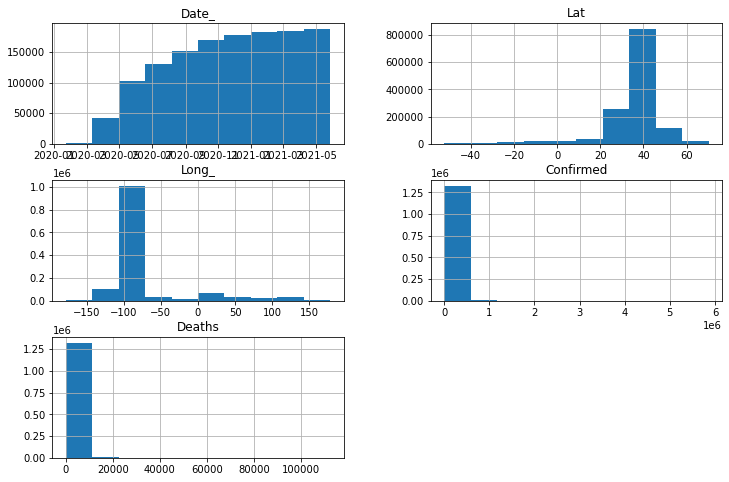

In [166]:
no_zeros_df.hist();

In [167]:
# Lets create a log10 of Confirmed and Deaths
log10_df = no_zeros_df[cols]
log10_df = np.log10(log10_df)

<AxesSubplot:xlabel='Confirmed'>

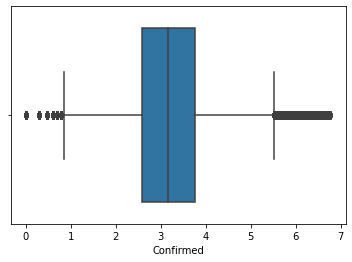

In [168]:
# Now plot Confirmed
plt.figure(figsize=(6, 4))
sns.boxplot(x=log10_df['Confirmed'])

<AxesSubplot:xlabel='Deaths'>

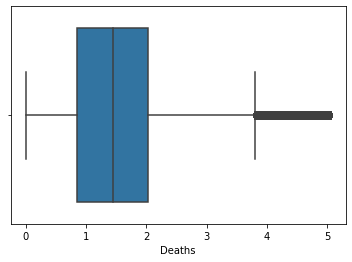

In [169]:
# Now plot Deaths
plt.figure(figsize=(6, 4))
sns.boxplot(x=log10_df['Deaths'])

As expected, no real insightful information to be gained from this.

#### Summary of Cleaning Issues

all_df
- We will need several versions of dataframes. Each question requires slightly different data to drive the result.
- There are nulls in all_df that we have filled backwards. The reason that we fill backwards is that we think that the reporting is slow. This is a time series. Filling backwards is close to the best value that we could get if not the best.

country_codes_df
- This has been data wrangled to successfully merge with all_df on the Country_Region column. 

pop_med_income_df
- This was data wrangled and should yield no issues while merging with all_df on the Country_Region column. Thereafter we will use the Alpha_3 column.

trans_int_df
- This dataset is clean and does not require any wrangling.

<a id='data_prep'></a>
# Data Preparation

As we go thru this notebook we will be transforming the data so that we can answer the questions posed. To start lets look at some global visualizations.

In [170]:
def plot_confirmed_death(df, place):
    """Plots daily running total of confirmed cases and deaths"""

    start = df.index[0].strftime('%Y-%m-%d')
    end = df.index[-1].strftime('%Y-%m-%d')
    title = ('From {} to {} Daily Running Total Statistics For Covid-19 ({})').format(start, end, place)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('# Of Cases and Deaths Per Day')
    plt.plot('Confirmed', data=df, color='orange', linewidth=2, label='Confirmed Cases')
    plt.plot('Deaths', data=df, linewidth=2, label='Deaths')
    plt.legend()
    plt.savefig(r'pics_final/running_totals.png');

In [171]:
def plot_mortality_rate(df, place):
    """Mortality rate plotted"""

    start = df.index[0].strftime('%Y-%m-%d')
    end = df.index[-1].strftime('%Y-%m-%d')
    title = ('From {} to {} Change in Mortality For Covid-19 ({})').format(start, end, place)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Mortality Rate')
    plt.plot('Mortality_Rate', data=df, linewidth=2, label='Deaths')
    plt.legend()
    plt.savefig(r'pics_final/mortality_rate.png');

In [172]:
def mortality_population(df, sign):
    """Plot the Deaths_e6. This is adjusted for population. It shows what countries are doing well or poorly
    considering their Median Income and Transparency International score"""
    
    sns.set_color_codes("pastel")
    sns.barplot(x="Deaths_e6", y="Country_Region", data=df,
                label="Deaths Per Million Population", palette="Blues_d")

    # Title
    title = ('Mortality Rate Per Million Population As of {}').format(end)
    plt.xlabel('Deaths Per Million')
    plt.title(title)
    
    # Construct legend
    legend_ = f'Includes Only Countries With {sign} 50% Median Per Capita Income and >= 60 on Transparency International Score'
    plt.legend([legend_])
    
    # Final housekeeping
    sns.despine(left=True, bottom=True)
    if sign == '<':
        plt.savefig(r'pics_final/honest_but_no_money.png');
    else:
        plt.savefig(r'pics_final/peer_group.png');

In [173]:
def regression_new_cases(df, place, days):
    """Number of New_Cases with Regression Line
    returns the slope and intercept of the line"""
    
    # Create the title
    end = df['Date_'].iloc[-1].strftime('%Y-%m-%d')
    title1 = (f'New Cases For Last {days} Days Prior To And Including {end} For Covid-19 With Regression Line ({place}) ')
    title2 = (f'\n{country} Has a Transparency International Score of {recent["TI_2019"].iloc[0]}')
    plt.title(title1 + title2)
    
    # We want the indexes in a list so we can place them on the x axis
    new_labels = df['Date_'].dt.strftime('%m-%d').tolist()
    plt.xticks(np.arange(len(new_labels)), new_labels)
    
    # Label the axis
    plt.xlabel('Consecutive Days')
    plt.ylabel('New_Cases Daily')
    
    # Create the plot
    p = sns.regplot(x=list(range(len(df))), y='New_Cases', data=df)
    
    # Create legend
    plt.legend(['New_Cases'], loc='upper center')
    
    # Make sure the plot is shown
    plt.show()
    
    # Save the figure
    plt.savefig(r'pics_final/' + place + '.jpg')

    # Calculate the slope and intercept
    slope, intercept, r_value, p_value, std_err = stats.linregress(x=p.get_lines()[0].get_xdata(),
                                                                   y=p.get_lines()[0].get_ydata())
    
    return slope, intercept

In [174]:
def regression_deaths(df, place):
    """Number of Deaths with Regression Line"""
    
    # Get start and end times of df
    start = df.index[0].strftime('%Y-%m-%d')
    end = df.index[-1].strftime('%Y-%m-%d')
    
    # Format the title and labels
    title = ('From {} to {} Daily Mortality For Covid-19 ({})').format(start, end, place)
    plt.title(title)
    plt.xlabel('Days')
    plt.ylabel('# Of Deaths Per Day')
    
    # Plot regression line
    sns.regplot(x=range(len(df)), y='Deaths', data=df, label='Deaths')
    
    # Legend
    plt.legend()
    
    # Save the chart
    plt.savefig(r'pics_final/running_totals.png');

In [175]:
def plot_world_map(q3_df, values):
    """Maps features onto a global map for visualization purposes"""
    
    # unpack values
    feature, legend_string, title_string = values
    
    fig = px.choropleth(q3_df, locations = "Alpha_3",
                        color = feature, 
                        hover_name = "Country_Region", # column to add to hover information
                        color_continuous_scale=px.colors.sequential.Turbo, 
                        title = title_string)
    fig.show()

In [176]:
def predict_deaths(df, place):

    # Add a new column that is Deaths_e6 (deaths per million)
    forecast_df['Deaths_e6'] = forecast_df['Deaths'] / 1000000

    # Assemble title
    start = forecast_df.index[0].strftime('%Y-%m-%d')
    title = ('{} Forecast Cumulative Deaths In Millions For Covid-19 ({} to {})').format(place, start, forecast_date)
    plt.title(title)

    # Create x and y axis labels
    plt.xlabel('Date')
    plt.ylabel('Cumulative Deaths In Millions')

    # Create plot
    plt.plot('Deaths_e6', data=forecast_df, linewidth=4, label='Deaths')
    plt.legend()
    plt.savefig(r'pics_final/' + place + '_prediction.png');

In [177]:
def calc_angle(df, a):
    """Calculates the angle of the regression line"""
    
    # Getting the length of all 3 sides
    # a is visualized based on a regression line of April 30 2020. This may change (obviously)
    b = (df.index[-1] - df.index[0]).days # Length of the dataframe (x axis).
    c = math.sqrt(a**2 + b**2)  # calculate the hypotenuse
    
    # Calculate the tangent
    tan = math.atan(a/b)
    angle = math.degrees(tan)
    
    return angle

In [178]:
def calc_deaths(angle, start, end):
    """Calculates the number of deaths based on the angle generated from calc_angle and days calculated from dates"""
    
    # Calculate the number of days for b (x axis / adjacent)
    start = dateutil.parser.parse(start)
    end = dateutil.parser.parse(end)
    days_ = end - start
    days_ = days_.days
    
    # Calculate the number of deaths (height / opposite)
    deaths = days_ * (math.tan(math.radians(angle)))
    
    return int(deaths), days_

In [179]:
def place_value(number): 
    """Changes number to a readable number with ','s for 000s'"""
    
    return ("{:,}".format(number))

### Create global_df

In [180]:
global_df = slim_df.groupby('Date_').sum()
global_df = global_df[['Confirmed', 'Deaths']]
global_df['Mortality_Rate'] = global_df['Deaths'] / global_df['Confirmed']
global_df.shape

(493, 3)

In [181]:
# Clip outliers for mortality
global_df = global_df[global_df['Mortality_Rate'] <= .1]
global_df.shape

(491, 3)

Occasionally there are data corrections that occur. This causes downstream machine learning challenges with plotting and the ARIMA model. Deal with this here now, by taking the mean of the outliers on those dates.

In [182]:
# Create a Daily Deaths column
global_df['Daily_Deaths'] = global_df['Deaths'] - global_df['Deaths'].shift()

If Daily_Deaths is negative, we have a problem. Take the average of the before Deaths row and the after Deaths row and use that as a plug value for the Deaths row where the Daily Deaths went negative. 

We could fix this with a .apply. However, that would loop thru a million plus rows and would take a long time. Lets use vector operations with Pandas.

First identify all of the negative instances. Take those rows PLUS the row before and row after and put them in a new temporary dataframe. In temp fix the values. Since python uses pointers this will update the values in the original global_df! 

In [183]:
temp = global_df[global_df['Daily_Deaths'] < 0]
temp

,Confirmed,Deaths,Mortality_Rate,Daily_Deaths
Date_,,,,
2020-02-01,12038.0,259.0,0.021515,-172.0
2020-08-17,21916638.0,774567.0,0.035342,-1160.0


In [184]:
row_index_list = []
for row in temp.itertuples():
    row_index = row.Index
    row_index_list.append(row_index)
row_index_list

[Timestamp('2020-02-01 00:00:00'), Timestamp('2020-08-17 00:00:00')]

In [185]:
for idx in range(len(row_index_list)):
    
    # Get start and end dates of rows of interest
    start_date_row = row_index_list[idx] - timedelta(days=1)
    end_date_row = row_index_list[idx] + timedelta(days=1)
    
    # Now that we have the rows, start the adjustments
    temp2 = global_df.loc[start_date_row: end_date_row, :]
    
    # Mean for Confirmed_Cases
    temp2.iloc[1,0] = (temp2.iloc[0,0] + temp2.iloc[-1,0]) / 2
    
    # Mean for Deaths
    temp2.iloc[1,1] = (temp2.iloc[0,1] + temp2.iloc[-1,1]) / 2
    
    # Fix Mortality
    temp2.iloc[1,2] = temp2.iloc[1,1] / temp2.iloc[1,0]
    
    display(temp2)

# Don't bother fixing Daily_Deaths. Just drop it.
global_df.drop('Daily_Deaths', axis=1, inplace=True) 
global_df.tail()

,Confirmed,Deaths,Mortality_Rate,Daily_Deaths
Date_,,,,
2020-01-31,9926.0,431.0,0.043421,84.0
2020-02-01,13356.5,396.5,0.029686,-172.0
2020-02-02,16787.0,362.0,0.021564,103.0


,Confirmed,Deaths,Mortality_Rate,Daily_Deaths
Date_,,,,
2020-08-16,21708939.0,775727.0,0.035733,4255.0
2020-08-17,21941907.5,778546.0,0.035482,-1160.0
2020-08-18,22174876.0,781365.0,0.035236,6798.0


,Confirmed,Deaths,Mortality_Rate
Date_,,,
2021-05-24,167316362.0,3473036.0,0.020757
2021-05-25,167848207.0,3485788.0,0.020768
2021-05-26,168416423.0,3498544.0,0.020773
2021-05-27,168970791.0,3511297.0,0.020780
2021-05-28,169470725.0,3523117.0,0.020789


In [186]:
global_df.describe()

,Confirmed,Deaths,Mortality_Rate
count,4.910000e+02,4.910000e+02,491.000000
mean,5.312042e+07,1.263721e+06,0.034540
std,5.268616e+07,1.064962e+06,0.015564
min,9.460000e+02,7.200000e+01,0.020408
25%,5.545244e+06,3.495125e+05,0.022019
50%,3.262668e+07,9.895440e+05,0.028452
75%,1.000492e+08,2.157162e+06,0.042869
max,1.694707e+08,3.523117e+06,0.076110


# Plot global mortality rate

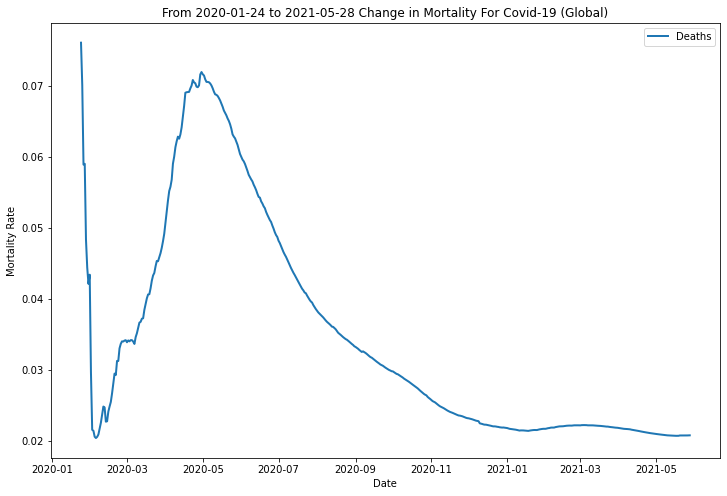

In [187]:
plot_mortality_rate(global_df, 'Global')

In [188]:
# Mortality rate as of the last day of this dataset
print(f'The global mortality rate for confirmed cases is currently\
 {round((global_df["Mortality_Rate"].iloc[-1])*100, 2)}%')

The global mortality rate for confirmed cases is currently 2.08%


It is extremely likely that the number of cases is at least 10 times higher than is being Confirmed. So, this mortality rate is likely 1/10 of the number shown here. Just google this to see all of the papers that are based on this under reporting "covid confirmed vs not reported cases what are the ratios".

In [189]:
global_df.describe()

,Confirmed,Deaths,Mortality_Rate
count,4.910000e+02,4.910000e+02,491.000000
mean,5.312042e+07,1.263721e+06,0.034540
std,5.268616e+07,1.064962e+06,0.015564
min,9.460000e+02,7.200000e+01,0.020408
25%,5.545244e+06,3.495125e+05,0.022019
50%,3.262668e+07,9.895440e+05,0.028452
75%,1.000492e+08,2.157162e+06,0.042869
max,1.694707e+08,3.523117e+06,0.076110


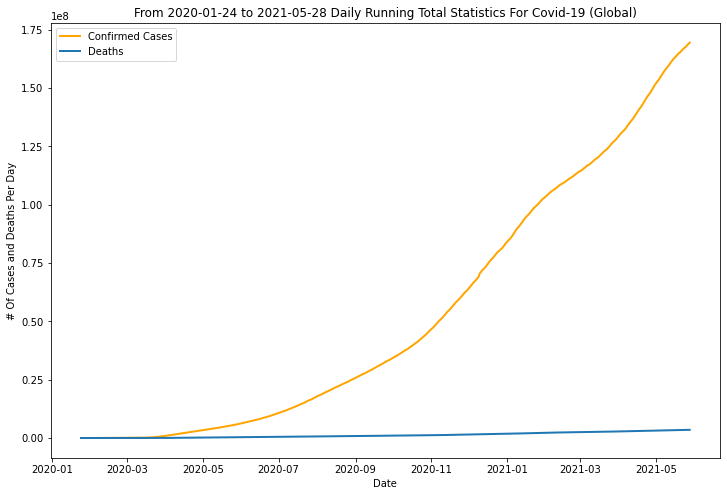

In [190]:
# Plot Confirmed and Deaths in one plot
plot_confirmed_death(global_df, 'Global')

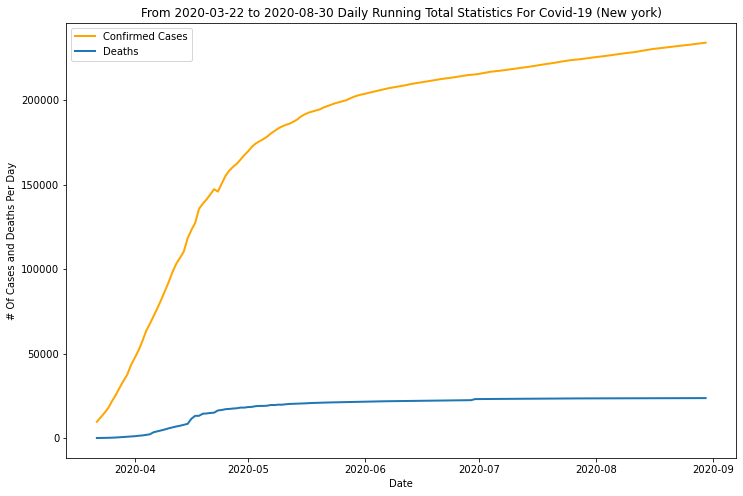

In [191]:
# Run plot for New York
new_york = all_df[all_df['Admin2'] == 'New York City'].copy(deep=True)
new_york.set_index('Date_', drop=True, inplace=True)
plot_confirmed_death(new_york, 'New york')

These are both VERY scary plots. They do not show any abatement or signs of flattening. If anything they have gone exponentially higher. 

### Question 1

Who are the best and worst countries dealing with Covid-19?

We need a dataframe that has these columns but we ONLY want the last date in the Covid-19 data. Then a groupby of that dataframe. Then to this dataframe we append Deaths_e6, Confirmed_e6,  Median_Income, and the Transparency International score.

In [192]:
# Now merge all_df with country_codes_df.
# First of all rename Country in country_codes_df to Country_Region to make the inner join simple
covid_pop_inc_df = all_df.merge(country_codes_df)
covid_pop_inc_df.head()

,Date_,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incident_Rate,Case_Fatality_Ratio,Incidence_Rate,Case-Fatality_Ratio,Alpha_3
0,2020-01-22,NaN,NaN,Unknown,China,1/22/2020 17:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHN
1,2020-01-23,NaN,NaN,Unknown,China,1/23/20 17:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHN
2,2020-01-24,NaN,NaN,Unknown,China,1/24/20 17:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHN
3,2020-01-25,NaN,NaN,Unknown,China,1/25/20 17:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHN
4,2020-01-26,NaN,NaN,Unknown,China,1/26/20 16:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHN


In [193]:
len(covid_pop_inc_df)

1661858

In [194]:
# Lets put covid_pop_inc_df on a diet
covid_pop_inc_df = covid_pop_inc_df[['Date_', 'Alpha_3', 'Country_Region', 'Lat', 'Long_', 'Confirmed', 'Deaths']]

In [195]:
covid_pop_inc_df.head()

,Date_,Alpha_3,Country_Region,Lat,Long_,Confirmed,Deaths
0,2020-01-22,CHN,China,NaN,NaN,NaN,NaN
1,2020-01-23,CHN,China,NaN,NaN,NaN,NaN
2,2020-01-24,CHN,China,NaN,NaN,NaN,NaN
3,2020-01-25,CHN,China,NaN,NaN,NaN,NaN
4,2020-01-26,CHN,China,NaN,NaN,NaN,NaN


In [196]:
pop_inc_cc_codes.head(1)

,Country_Region,Alpha_3,MPC_Inc,Pop2020,TI_2019
0,Afghanistan,AFG,378,38928346,16


In [197]:
pop_inc_cc_codes.dtypes

Country_Region    object
Alpha_3           object
MPC_Inc            int64
Pop2020            int64
TI_2019            int64
dtype: object

In [198]:
covid_pop_inc_df.dtypes

Date_             datetime64[ns]
Alpha_3                   object
Country_Region            object
Lat                      float64
Long_                    float64
Confirmed                float64
Deaths                   float64
dtype: object

In [199]:
covid_pop_inc_df.head(1)

,Date_,Alpha_3,Country_Region,Lat,Long_,Confirmed,Deaths
0,2020-01-22,CHN,China,NaN,NaN,NaN,NaN


In [200]:
q1_df = covid_pop_inc_df.groupby(['Date_','Alpha_3'], as_index=False)['Confirmed', 'Deaths'].sum()
end = q1_df.iloc[-1,0].strftime('%Y-%m-%d')
end

'2021-05-28'

In [201]:
q1_df = q1_df[q1_df['Date_'] == end]
print(q1_df.shape)
q1_df.head(1)

(188, 4)


,Date_,Alpha_3,Confirmed,Deaths
84062,2021-05-28,AFG,69130.0,2881.0


In [202]:
# Now we want to merge the population and median income data with this.
q1_df = q1_df.merge(pop_inc_cc_codes)
q1_df.head(1)

,Date_,Alpha_3,Confirmed,Deaths,Country_Region,MPC_Inc,Pop2020,TI_2019
0,2021-05-28,AFG,69130.0,2881.0,Afghanistan,378,38928346,16


In [203]:
# Now convert Confirmed and Deaths to a rate per million population
q1_df['Confirmed_e6'] = q1_df['Confirmed'] / (q1_df['Pop2020'] / 1000000)
q1_df['Deaths_e6'] = q1_df['Deaths'] / (q1_df['Pop2020'] / 1000000)
q1_df.head(1)

,Date_,Alpha_3,Confirmed,Deaths,Country_Region,MPC_Inc,Pop2020,TI_2019,Confirmed_e6,Deaths_e6
0,2021-05-28,AFG,69130.0,2881.0,Afghanistan,378,38928346,16,1775.826797,74.007768


In [204]:
# Make a copy of this df
q1_df_c = q1_df.copy(deep=True)

We do not think the reporting is correct for countries that are very poor. We are restricting our analysis to just the top 50% of all countries based on MedianPerCapitaIncome AND the country must have a Transparency International rating of 60 or over. The USA has a rating of 69. 

In [205]:
q1_df = q1_df[q1_df['TI_2019'] >= 60]
q1_median_income = int(q1_df['MPC_Inc'].median())
q1_df = q1_df[q1_df['MPC_Inc'] >= q1_median_income]
q1_df.sort_values('Deaths_e6', inplace=True)
print(q1_df.shape)
q1_df.head()

(14, 10)


,Date_,Alpha_3,Confirmed,Deaths,Country_Region,MPC_Inc,Pop2020,TI_2019,Confirmed_e6,Deaths_e6
83,2021-05-28,NZL,2670.0,26.0,New Zealand,12147,4822233,87,553.685398,5.391693
5,2021-05-28,AUS,30083.0,910.0,Australia,15026,25499884,77,1179.730857,35.686437
81,2021-05-28,NOR,124410.0,783.0,Norway,19308,5421241,84,22948.620067,144.431875
37,2021-05-28,FIN,92244.0,948.0,Finland,15725,5540720,86,16648.377828,171.096897
30,2021-05-28,DNK,279139.0,2513.0,Denmark,18262,5792201,87,48192.215705,433.859253


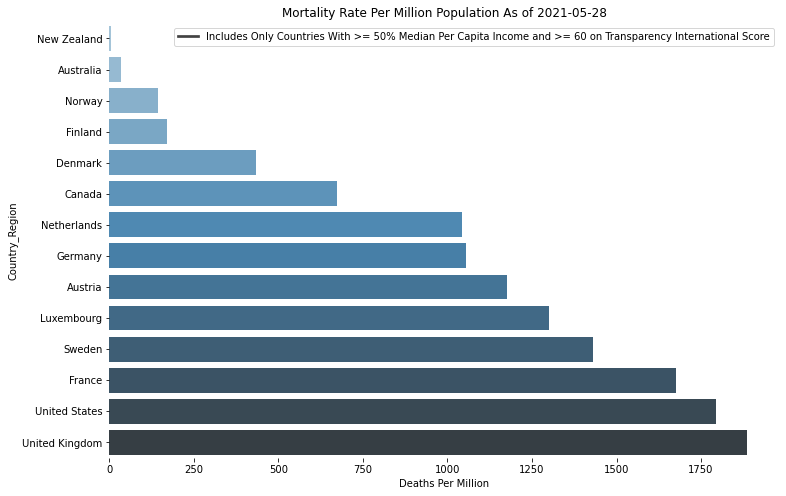

In [206]:
mortality_population(q1_df, '>=')

How many unique Alpha_3 codes (Country Codes) do we have in this dataset?

In [207]:
q1_df['Alpha_3'].nunique()

14

<a id='a1'></a>
### Answer to Question 1

> The above graph shows who is performing the best and the worst on the covid-19 pandemic. The only countries included in this bar graph have a Transparency International score of >= 60 and a MedianPerCapita Income >= 50% of the worlds countries. Countries with the shortest bars are doing better. Remember this IS adjusted for population. So, the fact that New Zealand is right at the top is remarkable. We should be looking at Australia and New Zealand to understand how they achieved this. 

> The USA is in the bottom third and the UK is at the very bottom. Perhaps a wake up call for their populations? The universe of countries that I chose for this was severely restricted by having the above cutoffs. As a result I feel this is a honest evaluation of the facts.

> One sobering thought here is that there are 203 unique Alpha_3 codes in this dataset. That corresponds to 203 countries. We are only looking at 28 of them. This is because of the concern over the honesty of the data. In otherwords the challenge that we are looking at here is only the tip of the iceberg. NB There are 195 countries in the world https://www.thoughtco.com/number-of-countries-in-the-world-1433445. The John Hopkins data has odd Country_Regions such as Cruise Ships. 

> I also looked at only countries that are "poor" but "honest" below.

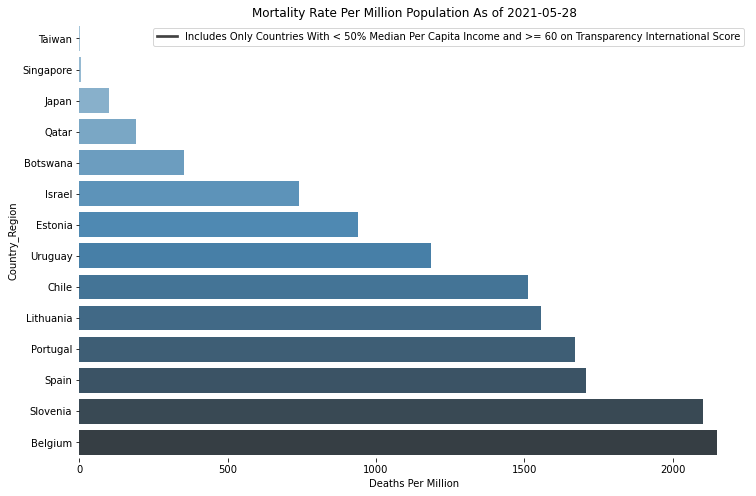

In [208]:
# Lets se how the other half lives:)
no_money_but_honest = q1_df_c[q1_df_c['TI_2019'] >= 60]
no_money_but_honest = no_money_but_honest[no_money_but_honest['MPC_Inc'] < q1_median_income]
no_money_but_honest.sort_values('Deaths_e6', inplace=True)

# Call the plotting function
mortality_population(no_money_but_honest, '<')

In [209]:
print(no_money_but_honest['Country_Region'].tolist())

['Taiwan', 'Singapore', 'Japan', 'Qatar', 'Botswana', 'Israel', 'Estonia', 'Uruguay', 'Chile', 'Lithuania', 'Portugal', 'Spain', 'Slovenia', 'Belgium']


Taiwan is an island and was very aware of the dangers due to its intimate relationship with China. Singapore has great control over its population. Botswana has a national health system, despite being a poor country. Japan is highly sophisticated but ... it is surprising they are on this list as having a lower Median Per Capita Income. They just missed the cutoff. 

### Question 2

Which countries have flattened or are flattening the curve?

We will take our universe of countries from a set that is twice as large as Q1 above and see if they are experiencing a flattening of the curve. The metric will be the last 14 days with a regression line. If the regression line is flat or going down, they are flattening the curve. 

In [210]:
# groupby that creates a sum for each date for each country (Alpha_3).
q2_df = covid_pop_inc_df.groupby(['Date_','Alpha_3'], as_index=False)['Confirmed', 'Deaths'].sum()
q2_df.head()

,Date_,Alpha_3,Confirmed,Deaths
0,2020-01-22,CHN,547.0,17.0
1,2020-01-22,HKG,0.0,0.0
2,2020-01-22,JPN,2.0,0.0
3,2020-01-22,KIR,0.0,0.0
4,2020-01-22,KOR,1.0,0.0


In [211]:
# Now we want to merge the population and median income data with this.
q2_df = q2_df.merge(pop_inc_cc_codes)
print(q2_df.shape)
q2_df.head(1)

(55706, 8)


,Date_,Alpha_3,Confirmed,Deaths,Country_Region,MPC_Inc,Pop2020,TI_2019
0,2020-01-22,CHN,547.0,17.0,China,1786,1439323775,41


In [212]:
# Need to add the column New_Cases
# Calculate # of New_Cases/day
q2_df['New_Cases'] = q2_df['Confirmed'] - q2_df['Confirmed'].shift(1) 
print(q2_df.shape)
q2_df.tail(5)

(55706, 9)


,Date_,Alpha_3,Confirmed,Deaths,Country_Region,MPC_Inc,Pop2020,TI_2019,New_Cases
55701,2021-05-24,TJK,13308.0,90.0,Tajikistan,713,9537645,25,0.0
55702,2021-05-25,TJK,13308.0,90.0,Tajikistan,713,9537645,25,0.0
55703,2021-05-26,TJK,13308.0,90.0,Tajikistan,713,9537645,25,0.0
55704,2021-05-27,TJK,13308.0,90.0,Tajikistan,713,9537645,25,0.0
55705,2021-05-28,TJK,13308.0,90.0,Tajikistan,713,9537645,25,0.0


In [213]:
q2_df.describe()

,Confirmed,Deaths,MPC_Inc,Pop2020,TI_2019,New_Cases
count,5.570600e+04,55706.000000,55706.000000,5.570600e+04,55706.000000,5.570500e+04
mean,4.538419e+05,10900.156967,4091.770294,6.068714e+07,44.850321,2.290818e-01
std,2.010484e+06,40156.061608,4889.355308,1.887740e+08,19.242282,2.071921e+05
min,0.000000e+00,0.000000,47.000000,4.415430e+05,13.000000,-3.323996e+07
25%,2.411250e+03,52.000000,623.000000,5.850342e+06,30.000000,1.300000e+01
50%,3.261250e+04,577.000000,1902.000000,1.642586e+07,41.000000,2.050000e+02
75%,2.066292e+05,4690.500000,5236.000000,4.385104e+07,58.000000,1.208000e+03
max,3.323996e+07,593963.000000,19308.000000,1.439324e+09,87.000000,8.232250e+05


In [214]:
# Whoops there are some outliers here.
q2_df[q2_df['New_Cases'] < 0]

,Date_,Alpha_3,Confirmed,Deaths,Country_Region,MPC_Inc,Pop2020,TI_2019,New_Cases
133,2020-06-03,CHN,84160.0,4638.0,China,1786,1439323775,41,-1.0
493,2020-01-22,HKG,0.0,0.0,Hong Kong,9705,7496981,76,-102948.0
589,2020-03-10,HKG,120.0,3.0,Hong Kong,9705,7496981,76,-110.0
591,2020-01-22,JPN,2.0,0.0,Japan,10840,126476461,73,-118.0
592,2020-01-23,JPN,1.0,0.0,Japan,10840,126476461,73,-1.0
...,...,...,...,...,...,...,...,...,...
54080,2020-03-31,SLE,1.0,0.0,Sierra Leone,233,7976983,33,-4668.0
54504,2020-04-10,YEM,1.0,0.0,Yemen,400,29825964,15,-4139.0
54627,2020-08-11,YEM,1831.0,523.0,Yemen,400,29825964,15,-1.0
54918,2020-04-30,COM,1.0,0.0,Comoros,598,869601,25,-6722.0


In [215]:
# 0 out the offending values. We are just looking for a regression line here.
# That is probably the least harmful cleaning alternative.
q2_df['New_Cases'] = q2_df['New_Cases'].apply(lambda x: 0 if x < 0 else x)
q2_df.describe()

,Confirmed,Deaths,MPC_Inc,Pop2020,TI_2019,New_Cases
count,5.570600e+04,55706.000000,55706.000000,5.570600e+04,55706.000000,55705.000000
mean,4.538419e+05,10900.156967,4091.770294,6.068714e+07,44.850321,2959.317189
std,2.010484e+06,40156.061608,4889.355308,1.887740e+08,19.242282,14626.729790
min,0.000000e+00,0.000000,47.000000,4.415430e+05,13.000000,0.000000
25%,2.411250e+03,52.000000,623.000000,5.850342e+06,30.000000,13.000000
50%,3.261250e+04,577.000000,1902.000000,1.642586e+07,41.000000,205.000000
75%,2.066292e+05,4690.500000,5236.000000,4.385104e+07,58.000000,1208.000000
max,3.323996e+07,593963.000000,19308.000000,1.439324e+09,87.000000,823225.000000


In [216]:
# Now convert New_Casess to a rate per million population
q2_df['New_Cases_e6'] = q2_df['Confirmed'] / (q2_df['Pop2020'] / 1000000)
q2_df.head(1)

,Date_,Alpha_3,Confirmed,Deaths,Country_Region,MPC_Inc,Pop2020,TI_2019,New_Cases,New_Cases_e6
0,2020-01-22,CHN,547.0,17.0,China,1786,1439323775,41,NaN,0.38004


In [217]:
q2_df.sort_values(['Date_', 'Alpha_3'], inplace=True)
print(q2_df.shape)
q2_df.tail()

(55706, 10)


,Date_,Alpha_3,Confirmed,Deaths,Country_Region,MPC_Inc,Pop2020,TI_2019,New_Cases,New_Cases_e6
3055,2021-05-28,USA,33239963.0,593963.0,United States,15480,331002651,69,21968.0,100422.044656
6873,2021-05-28,VNM,6396.0,47.0,Vietnam,1124,97338579,37,40.0,65.708787
54917,2021-05-28,YEM,6723.0,1316.0,Yemen,400,29825964,15,27.0,225.407635
34227,2021-05-28,ZAF,1654551.0,56293.0,South Africa,1217,59308690,44,4574.0,27897.277785
49320,2021-05-28,ZMB,94430.0,1275.0,Zambia,287,18383955,34,483.0,5136.544340


In [218]:
# This is the df that we need for q4. Lets make a copy of it.
q4_df = q2_df.copy(deep=True)

In [219]:
# Need the date of the last row in the df
end = q2_df.iloc[-1,0]
end

Timestamp('2021-05-28 00:00:00')

In [220]:
# We want the date x days ago
days = 14
start = end - timedelta(days=days)
start

Timestamp('2021-05-14 00:00:00')

In [221]:
q2_df = q2_df[q2_df['Date_'] >= start]
q2_df.shape

(1830, 10)

We do not think the reporting is correct. We are restricting our analysis to countries that have a Transparency International rating >= 60. The USA has a rating of 69. 

In [222]:
q2_df = q2_df[q2_df['TI_2019'] >= 60]
print(q2_df.shape)
q2_df.head()

(420, 10)


,Date_,Alpha_3,Confirmed,Deaths,Country_Region,MPC_Inc,Pop2020,TI_2019,New_Cases,New_Cases_e6
3532,2021-05-14,AUS,29964.0,910.0,Australia,15026,25499884,77,7.0,1175.064169
17850,2021-05-14,AUT,635780.0,10455.0,Austria,12284,9006398,77,887.0,70592.039126
14150,2021-05-14,BEL,1028104.0,24664.0,Belgium,10189,11589623,75,1631.0,88709.011501
53641,2021-05-14,BWA,49656.0,761.0,Botswana,740,2351627,61,615.0,21115.593587
8329,2021-05-14,CAN,1326989.0,24857.0,Canada,15181,37742154,77,6783.0,35159.334043


In [223]:
# Get a list with no duplicates from Country_Region
countries = q2_df['Country_Region'].tolist()
countries = (set(countries))
countries = list(countries)
countries.sort()
print(len(countries))
print(countries)

28
['Australia', 'Austria', 'Belgium', 'Botswana', 'Canada', 'Chile', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Israel', 'Japan', 'Lithuania', 'Luxembourg', 'Netherlands', 'New Zealand', 'Norway', 'Portugal', 'Qatar', 'Singapore', 'Slovenia', 'Spain', 'Sweden', 'Taiwan', 'United Kingdom', 'United States', 'Uruguay']


In [224]:
# Did not run this one because the output was too small to be of use. 
# I include it here because if I was reviewing this I would ask why I did not use FacetGrid.

# g = sns.FacetGrid(q2_df, col="Country_Region", col_wrap=4, height=2)
# g.map(sns.pointplot, 'Date_String', 'New_Cases', order=date_string, color=".3", ci=None);

We run the below regression plot in full size. In small size (above), you lose the details of whether or not the # of New_Cases is trending up or down.

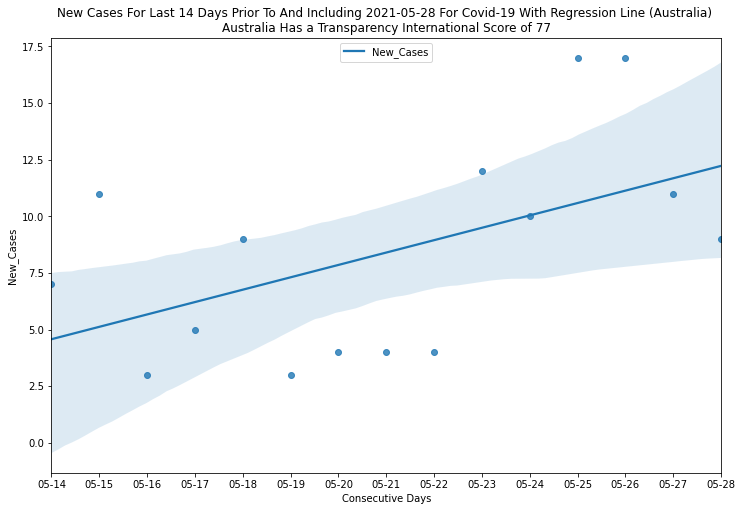

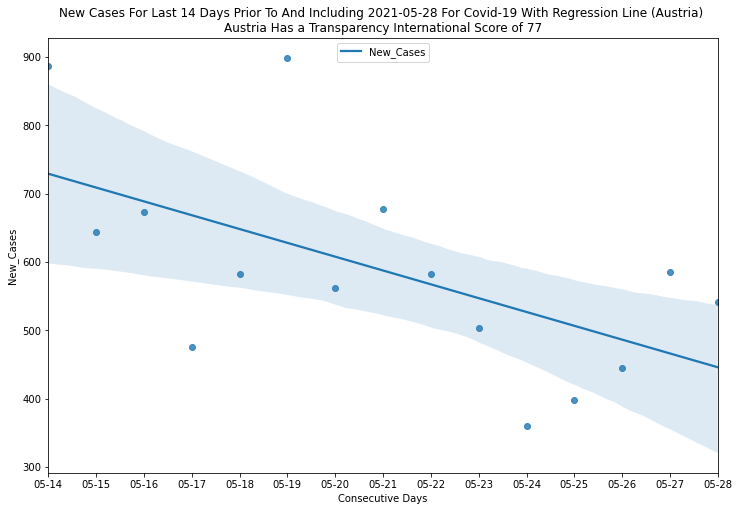

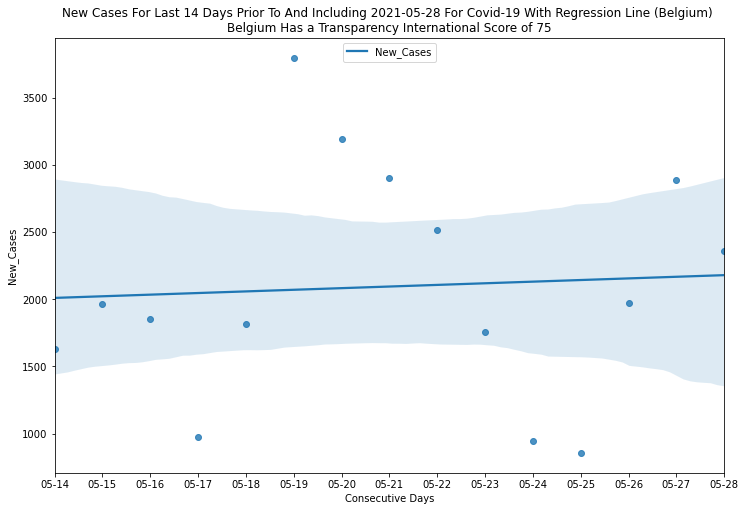

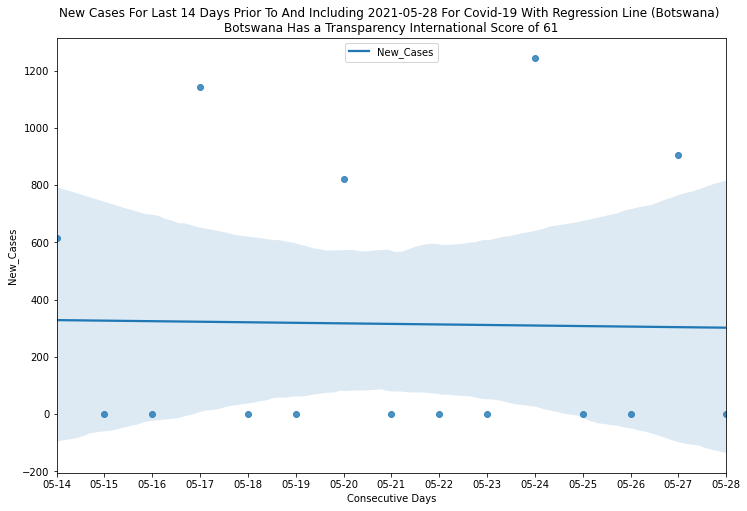

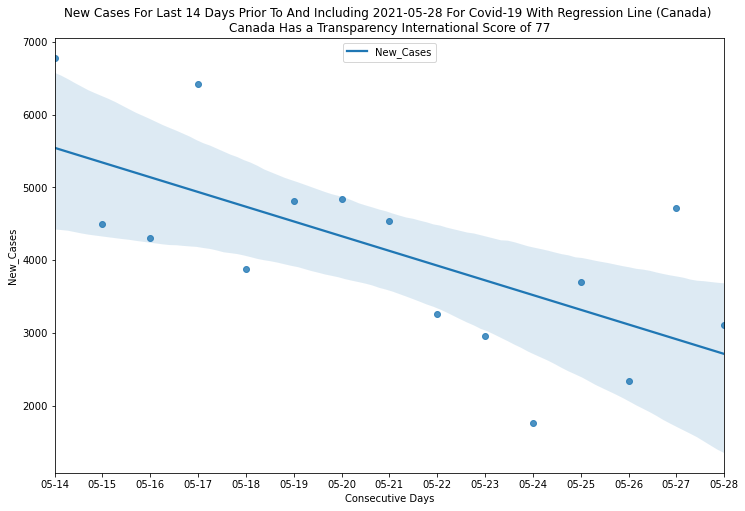

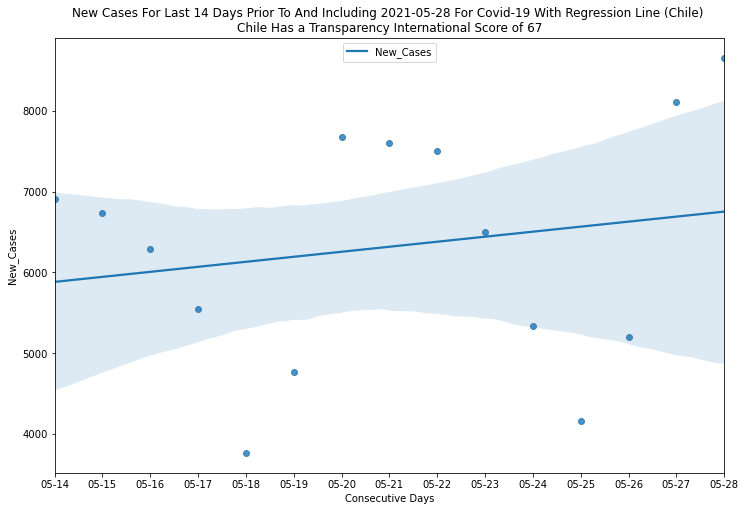

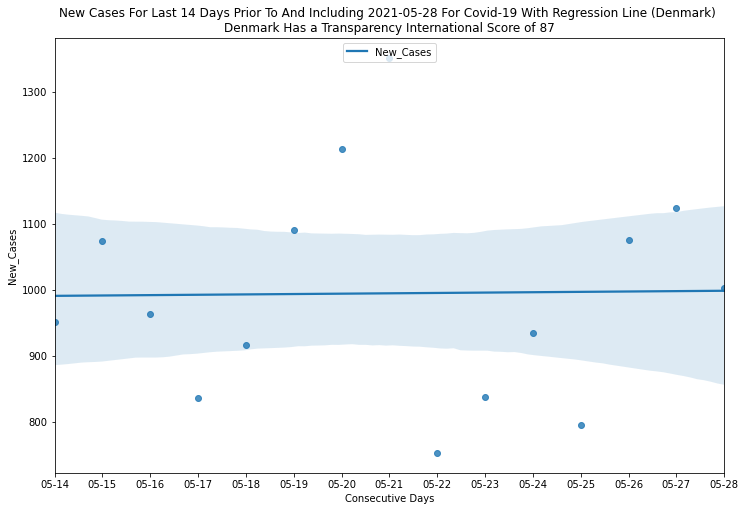

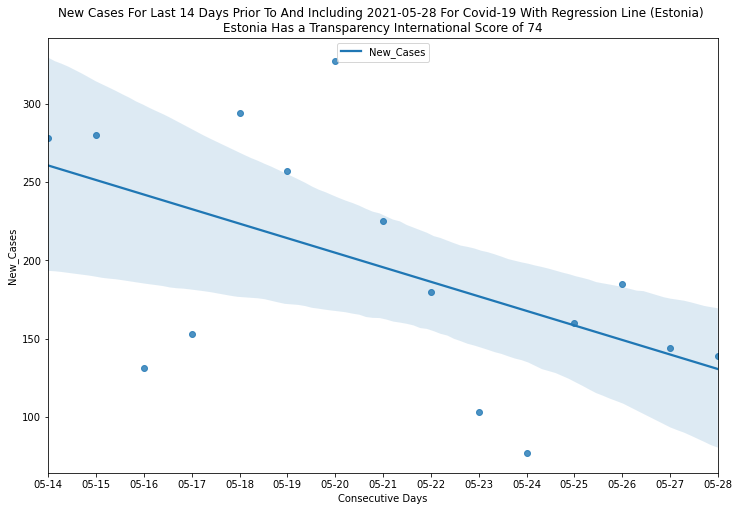

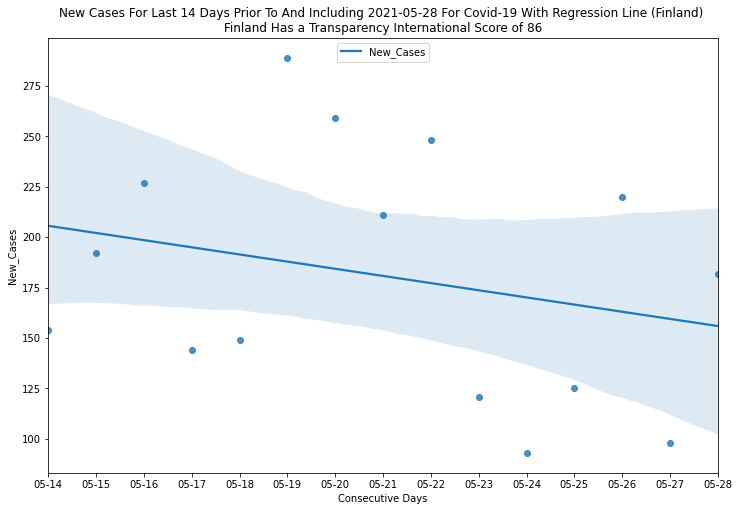

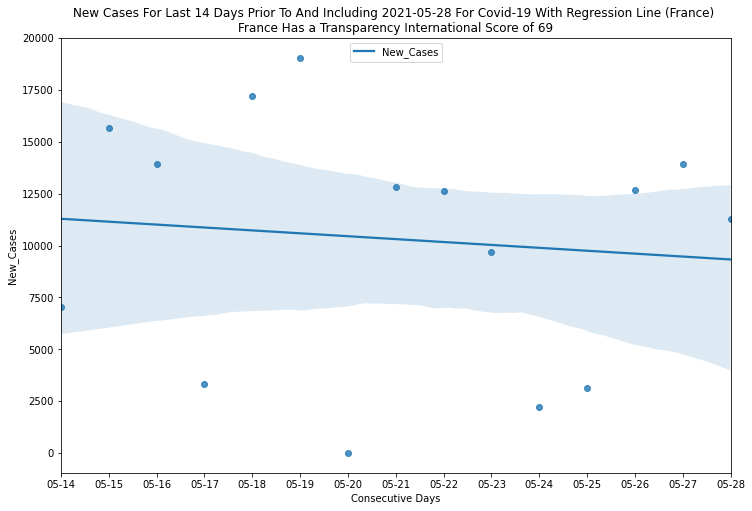

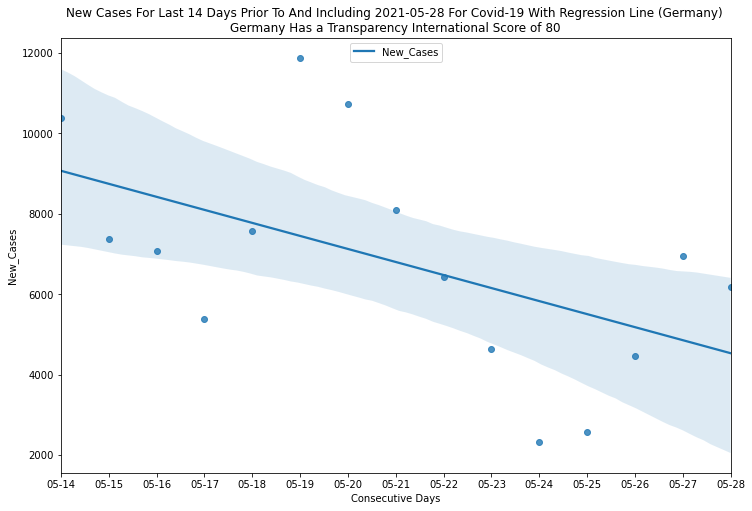

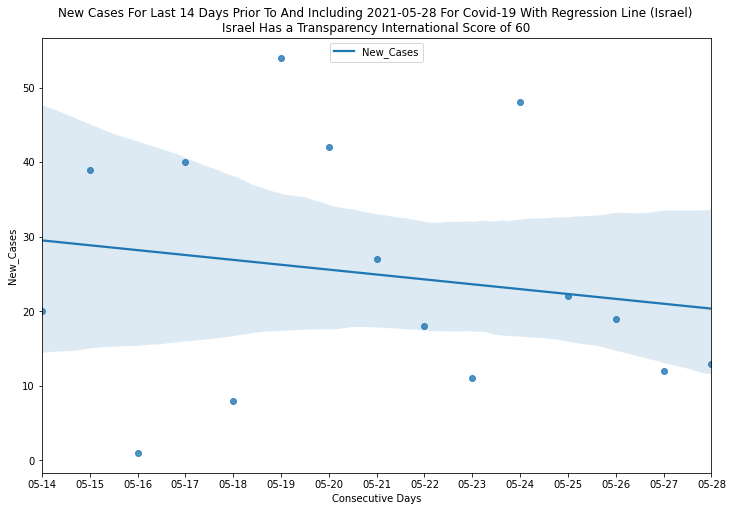

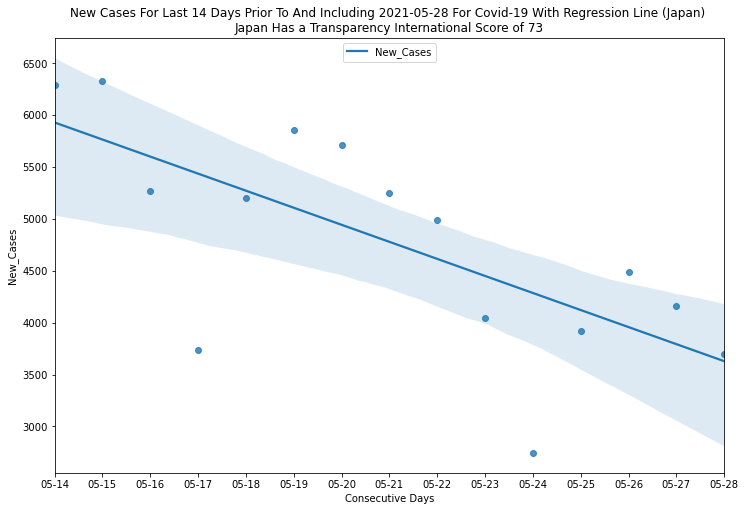

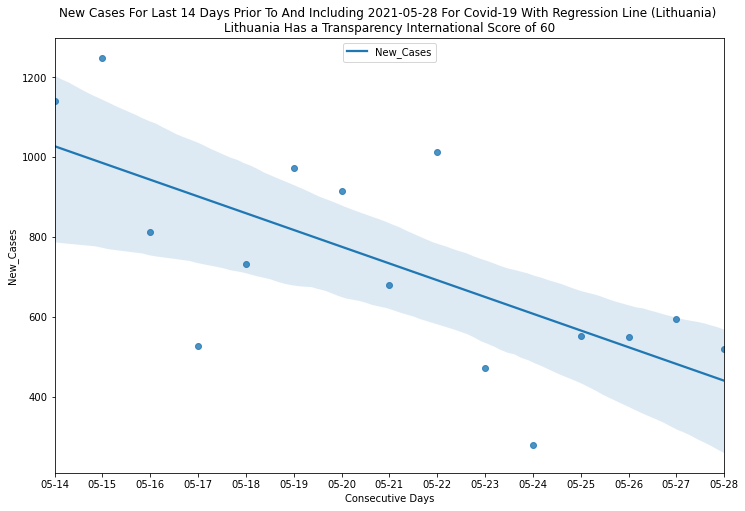

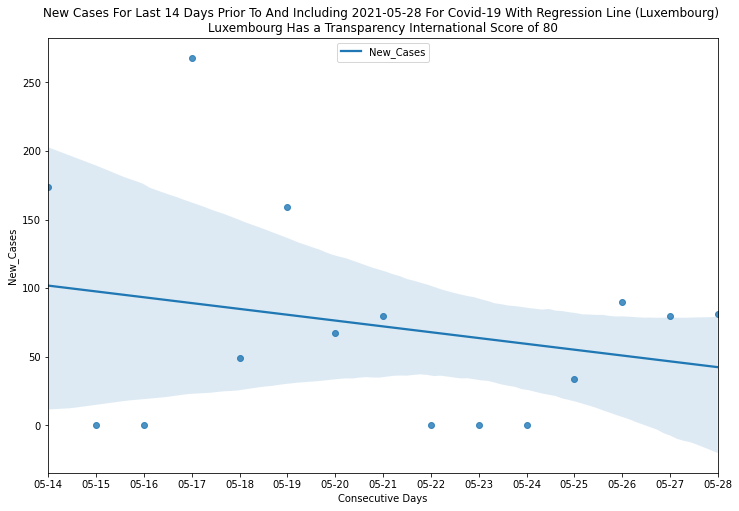

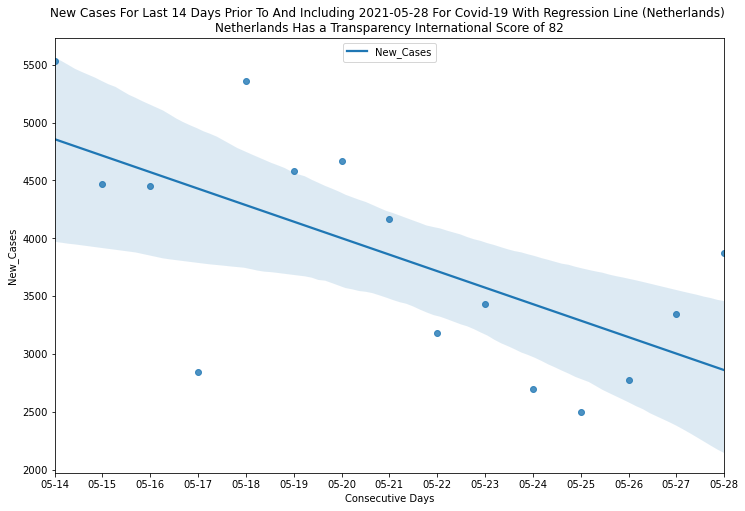

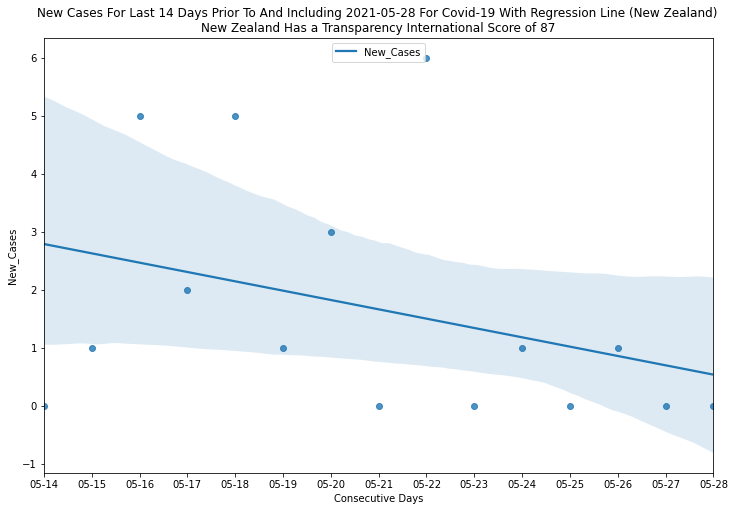

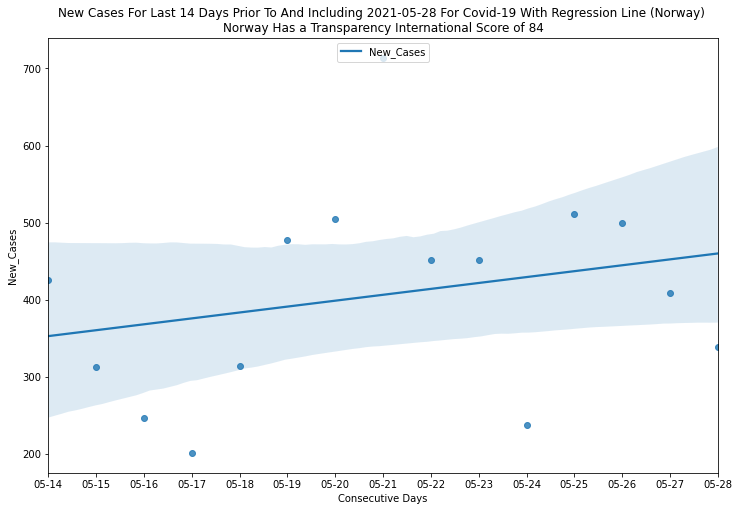

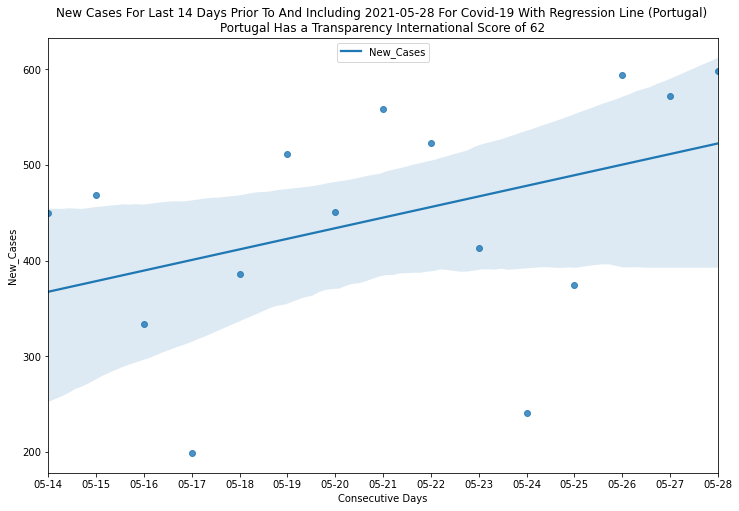

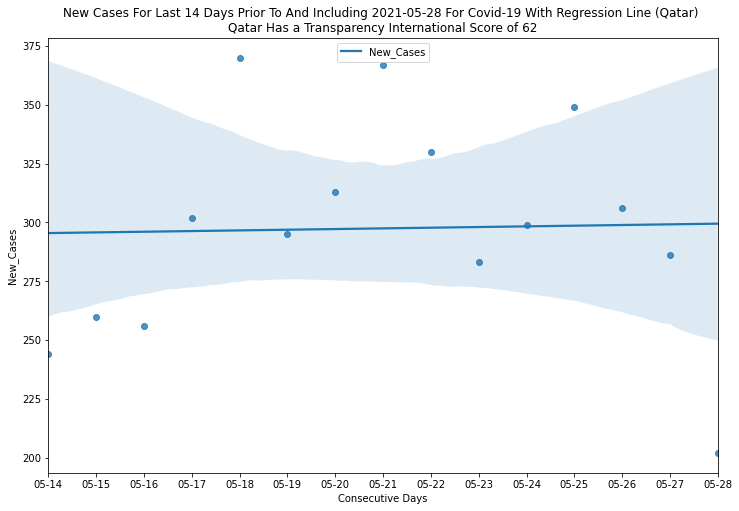

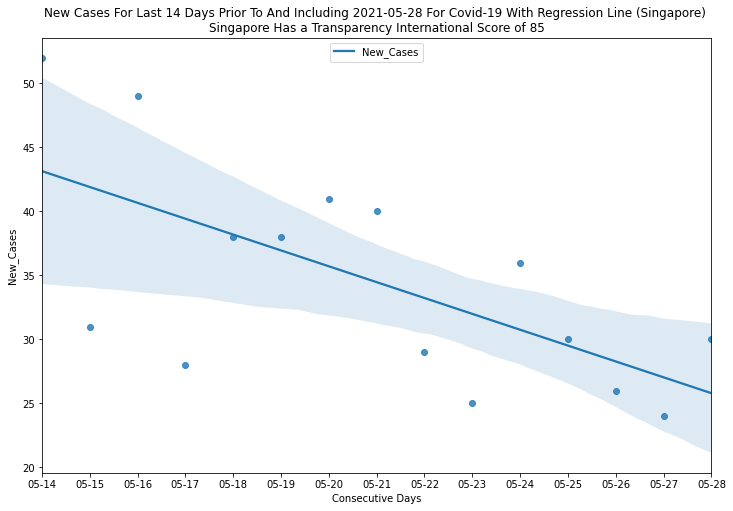

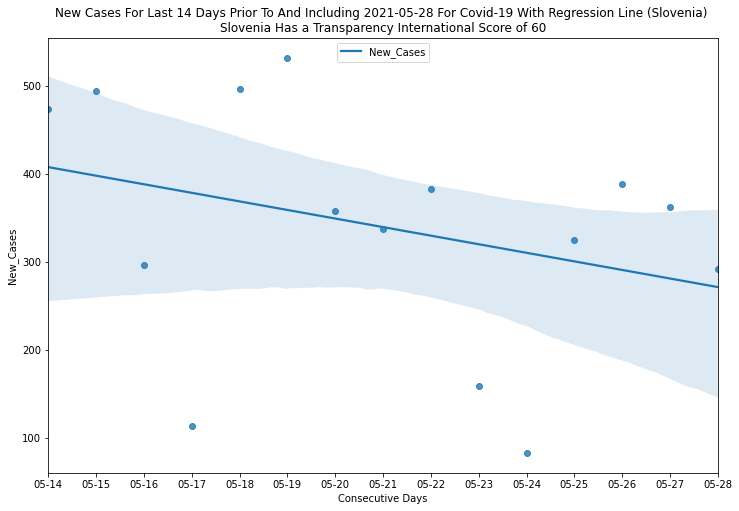

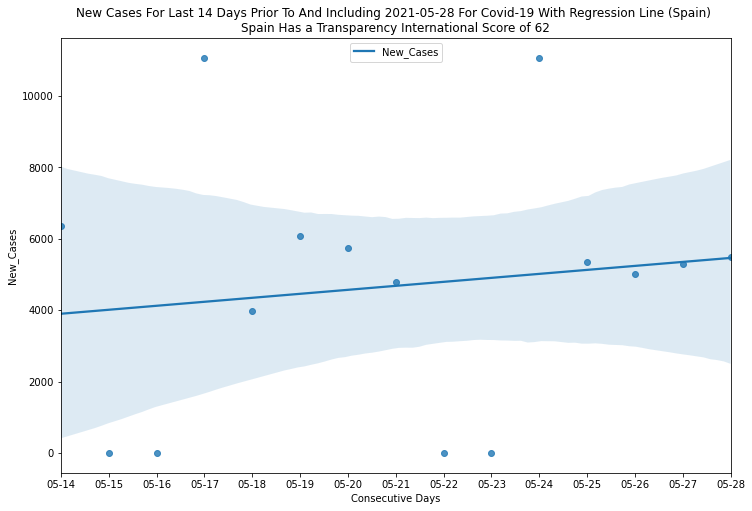

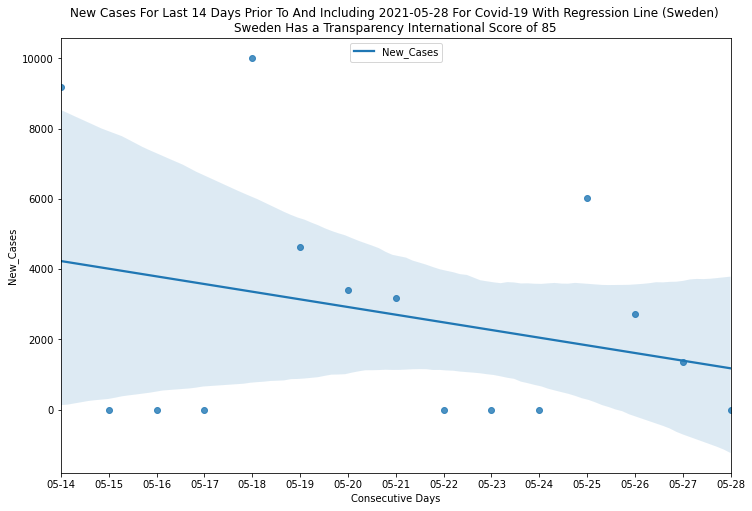

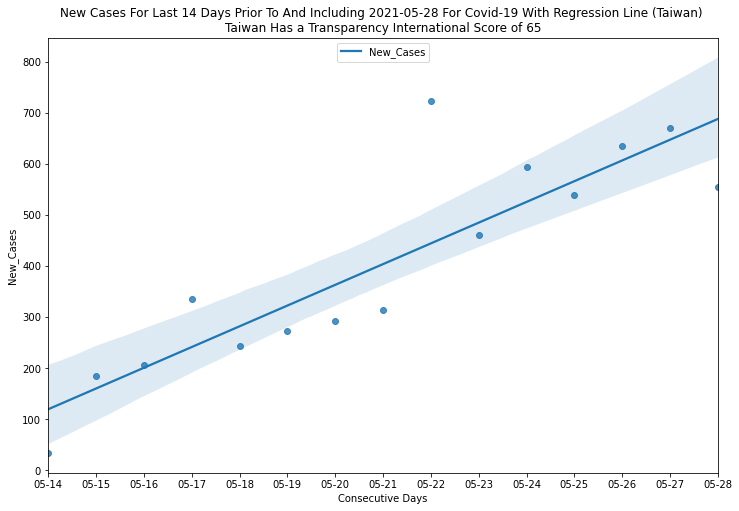

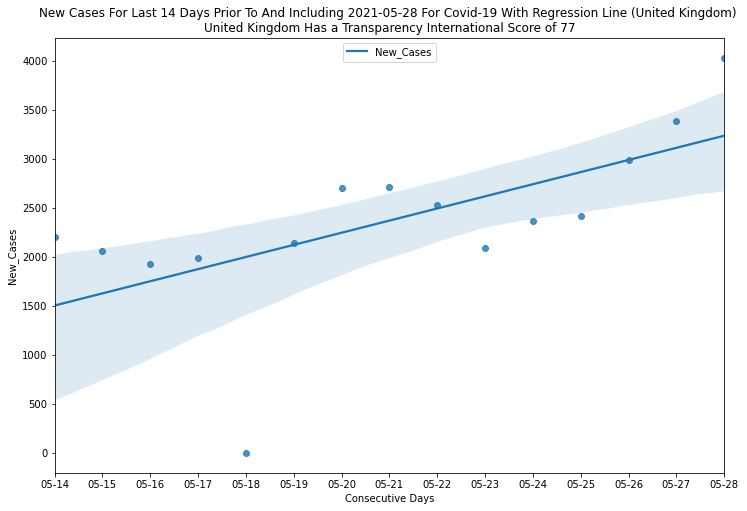

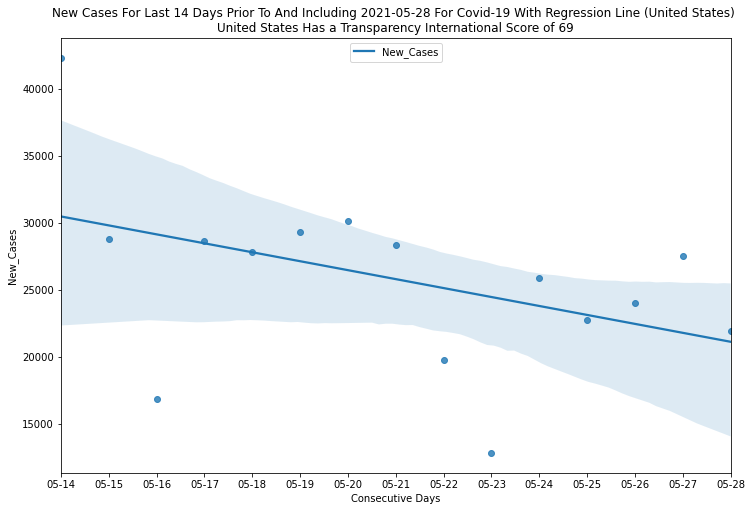

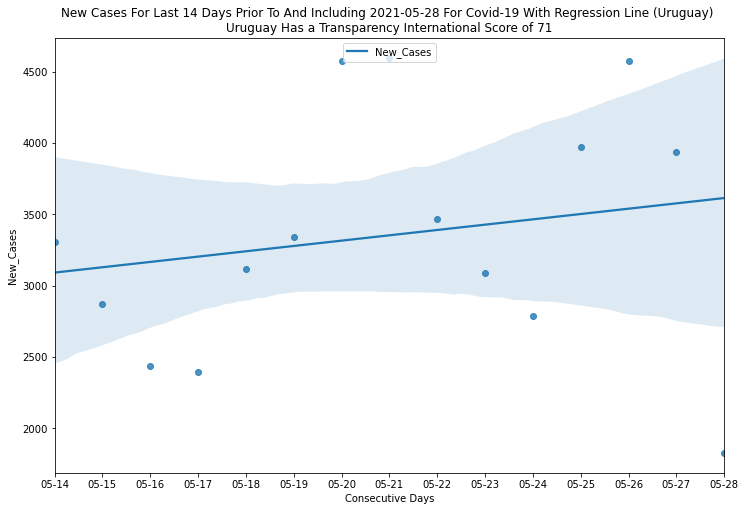

<Figure size 864x576 with 0 Axes>

In [225]:
# Run regression line plot and put countries into the appropriate list.
flat = []
falling = []
rising = []


for country in countries:

    # Just the country of interest
    recent = q2_df[q2_df['Country_Region'] == country]
    
    # Plot
    slope, intercept = regression_new_cases(recent, country, days)
    
    # Check for flat
    if  abs(slope) / intercept < .005:
        flat.append(country)
    
    # Check for falling
    elif slope < 0:
        falling.append(country)
        
    # Else rising
    else:
        rising.append(country)

In [226]:
print('flat\n', sorted(flat))
print('\nfalling \n', sorted(falling))
print('\nrising \n', sorted(rising))

flat
 ['Denmark', 'Qatar']

falling 
 ['Austria', 'Botswana', 'Canada', 'Estonia', 'Finland', 'France', 'Germany', 'Israel', 'Japan', 'Lithuania', 'Luxembourg', 'Netherlands', 'New Zealand', 'Singapore', 'Slovenia', 'Sweden', 'United States']

rising 
 ['Australia', 'Belgium', 'Chile', 'Norway', 'Portugal', 'Spain', 'Taiwan', 'United Kingdom', 'Uruguay']


<a id='a2'></a>
### Answer to Question 2

> The above graphs show you the flat, rising, and falling regression lines for each country. The flat list contains the countries that have daily flat numbers of New_Cases of covid-19. The falling list are those countries that have lower numbers of New_Cases over the 14 day period. The rising list are the countries where increased trouble is very close at hand. 

> We do not cutoff based on Median Per Capita Income on this list. The only cutoff is the Transparency International score. That is why we have ~ twice as many countries being considered.

### Question 3

Can I see a global geographic representation of infections?

Yes, however, we are only going to do this for the last date that we have data on. The John Hopkins dashboard at https://coronavirus.jhu.edu/map.html is an impressive interactive facility that has the ability to visualize data geographically at a much greater level of sophistication than what I will be doing here. The purpose here was to append demographic information (population and Median Per Capita Income) and a "honesty score" via the Transparency International score so that we cam gain some confidence about the usefulness of this data. 

In [227]:
# groupby that creates a sum for each date for each country (Alpha_3).
q3_df = covid_pop_inc_df.groupby(['Date_','Alpha_3'], as_index=False)['Confirmed', 'Deaths'].sum()
q3_df.head()

,Date_,Alpha_3,Confirmed,Deaths
0,2020-01-22,CHN,547.0,17.0
1,2020-01-22,HKG,0.0,0.0
2,2020-01-22,JPN,2.0,0.0
3,2020-01-22,KIR,0.0,0.0
4,2020-01-22,KOR,1.0,0.0


In [228]:
# Now we want to merge the population and median income data with this.
q3_df = q3_df.merge(pop_inc_cc_codes)
print(q3_df.shape)
q3_df.head(1)

(55706, 8)


,Date_,Alpha_3,Confirmed,Deaths,Country_Region,MPC_Inc,Pop2020,TI_2019
0,2020-01-22,CHN,547.0,17.0,China,1786,1439323775,41


In [229]:
# Restrict the analysis to just the most recent date for data
q3_df = q3_df[q3_df['Date_'] == end]
q3_df.sort_values('Country_Region', inplace=True)
print(q3_df.shape)
q3_df.tail()

(122, 8)


,Date_,Alpha_3,Confirmed,Deaths,Country_Region,MPC_Inc,Pop2020,TI_2019
3055,2021-05-28,USA,33239963.0,593963.0,United States,15480,331002651,69
46691,2021-05-28,URY,282198.0,4118.0,Uruguay,2488,3473730,71
6873,2021-05-28,VNM,6396.0,47.0,Vietnam,1124,97338579,37
54917,2021-05-28,YEM,6723.0,1316.0,Yemen,400,29825964,15
49320,2021-05-28,ZMB,94430.0,1275.0,Zambia,287,18383955,34


In [230]:
q3_df.describe()

,Confirmed,Deaths,MPC_Inc,Pop2020,TI_2019
count,1.220000e+02,122.000000,122.000000,1.220000e+02,122.000000
mean,1.347294e+06,28268.303279,3981.016393,5.843516e+07,44.409836
std,4.222437e+06,78337.876296,4848.304543,1.836940e+08,19.193988
min,5.090000e+02,6.000000,47.000000,4.415430e+05,13.000000
25%,5.795825e+04,850.750000,617.750000,6.009308e+06,29.250000
50%,2.573000e+05,3792.500000,1790.500000,1.468904e+07,40.000000
75%,8.017610e+05,17292.250000,5162.000000,4.382039e+07,57.500000
max,3.323996e+07,593963.000000,19308.000000,1.439324e+09,87.000000


In [231]:
q3_df.isnull().mean()

Date_             0.0
Alpha_3           0.0
Confirmed         0.0
Deaths            0.0
Country_Region    0.0
MPC_Inc           0.0
Pop2020           0.0
TI_2019           0.0
dtype: float64

Above looks fine

In [232]:
# Add column for Deaths Per Million
q3_df['Deaths_e6'] = q3_df['Deaths'] / (q3_df['Pop2020'] / 1000000)

In [233]:
# Get numeric column names
num_cols = q3_df.select_dtypes([np.number]).columns
num_cols

Index(['Confirmed', 'Deaths', 'MPC_Inc', 'Pop2020', 'TI_2019', 'Deaths_e6'], dtype='object')

In [234]:
# Instantiate a dictionary with the numeric feature columns
feature_dict = dict(zip(num_cols, range(len(num_cols))))
feature_dict

{'Confirmed': 0,
 'Deaths': 1,
 'MPC_Inc': 2,
 'Pop2020': 3,
 'TI_2019': 4,
 'Deaths_e6': 5}

In [235]:
# We have the plot code in a function, Run all of the numeric columns thru this.
# First create a dictionary with the appropriate strings
feature_dict.update({num_cols[0]: ['Confirmed', 'Fewest Cases', 'Covid-19 Confirmed Cases By Country'],
                    num_cols[1]: ['Deaths', 'Fewest Deaths', 'Covid-19 Deaths By Country'],
                    num_cols[2]: ['MPC_Inc', 'Lowest', 'Median Per Capita Income By Country'],
                    num_cols[3]: ['Pop2020', 'Lowest', 'Population By Country'],
                    num_cols[4]: ['TI_2019', 'Least Honest', 'Transparency International Score By Country'],
                    num_cols[5]: ['Deaths_e6', 'Fewest Deaths', 'Covid-19 Deaths By Country Per Million Population']
                   })

In [236]:
# Prepare map for all features
for feature in num_cols:
    plot_world_map(q3_df, feature_dict[feature])

<a id='a3'></a>
### Answer to Question 3

> The above images quickly tell you where the challenges are. Any country that shows color on the 'Covid-19 Deaths By Country Adjusted For Population' map is in trouble. The grey countries are not reporting data. If you look at the 'Transparency International Score By Country' (right above that one), you can immediately see the issue about reporting. Countries that are honest are reporting and as a result report higher deaths. The vast majority of countries are either not reporting or are "not honest". 

<a id='model'></a>
# Model Data


### Question 4

What is the projected global mortality by December 31, 2020?

The way we are going to answer this is to look at a correlation heat map. That will instruct as to what variable would be helpful in terms of predicting deaths. Then we are simply going to do a simple regression line and extend it using trigonometry. Finally I will run an ARMIM model that predicts every day going forward to the end of 2020.

In [237]:
# Look at df just to remind me of what I have.
q4_df.head(1)

,Date_,Alpha_3,Confirmed,Deaths,Country_Region,MPC_Inc,Pop2020,TI_2019,New_Cases,New_Cases_e6
0,2020-01-22,CHN,547.0,17.0,China,1786,1439323775,41,NaN,0.38004


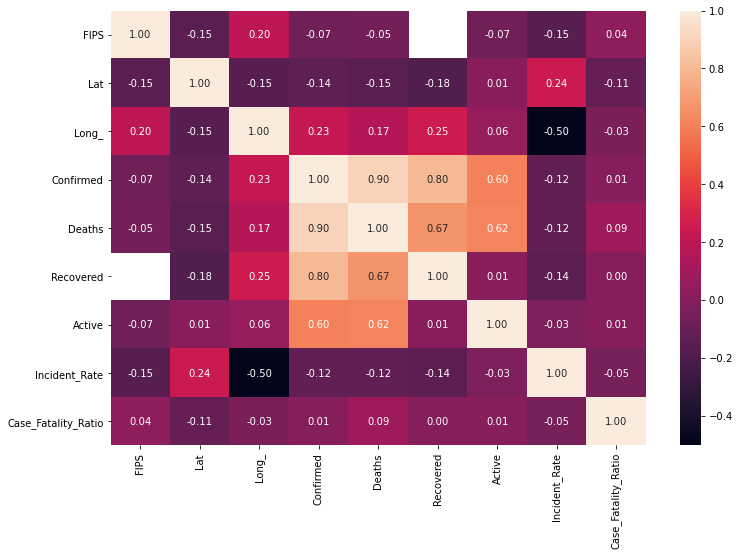

In [238]:
# Look at the correlations. Should be pretty good.
sns.heatmap(df.corr(), annot=True, fmt=".2f");

The correlation is very high between Confirmed and Deaths. There are obvious cases of multicollinearity in the features that are in this dataset (Confirmed, Recovered, Active). There is considerable uncertainty about the quality of the data that is being reported. We  want to predict to the end of 2020 what will be the total number of global deaths. 

We simply do not need all of the complexity of the q4_df dataset to answer this question. The global_df that we created earlier in the notebook works quite well for this. It is created via a groupby on Date_ with a sum. This yields the following very simple dataset after dropping a few columns. Remember though, for Confirmed and for Deaths the numbers are cumulative. Mortality_Rate is a simple division based on the previous 2 columns.


#### ARIMA Model

I have a number of features that we could use to predict mortality. However, the obvious one is to simply use Death. This machine learning algorithm is well suited to univariate time series. 

Lets see what is going to happen to the USA.

Create and summarize a stationary version of the time series. 

In [239]:
# check if stationary
# Create a Daily Deaths column
global_df['Daily_Deaths'] = global_df['Deaths'] - global_df['Deaths'].shift()
global_df.dropna(inplace=True)
stationary = global_df['Daily_Deaths'].values
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.222447
p-value: 0.198200
Critical Values:
	1%: -3.444
	5%: -2.868
	10%: -2.570


In [240]:
global_df.tail(20)

,Confirmed,Deaths,Mortality_Rate,Daily_Deaths
Date_,,,,
2021-05-09,158330372.0,3293188.0,0.020799,9902.0
2021-05-10,158952301.0,3303957.0,0.020786,10769.0
2021-05-11,159690774.0,3317579.0,0.020775,13622.0
2021-05-12,160450873.0,3331516.0,0.020763,13937.0
2021-05-13,161176148.0,3344655.0,0.020752,13139.0
2021-05-14,161894208.0,3357785.0,0.020741,13130.0
2021-05-15,162521726.0,3369435.0,0.020732,11650.0
2021-05-16,163069932.0,3379526.0,0.020724,10091.0
2021-05-17,163609626.0,3390170.0,0.020721,10644.0


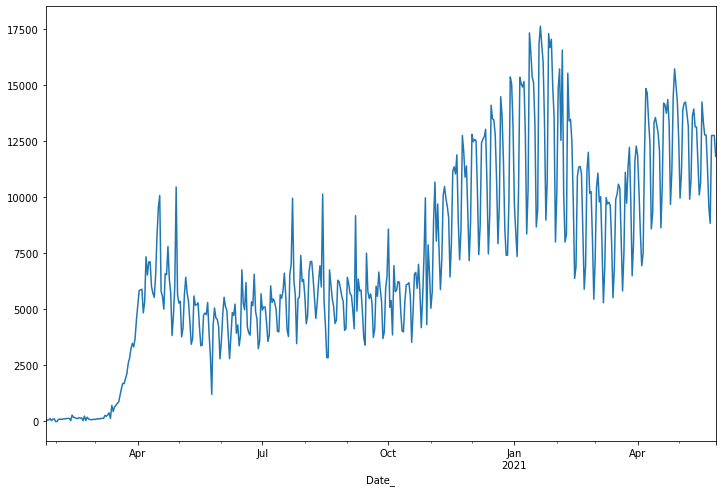

In [241]:
# plot differenced data
global_df['Daily_Deaths'].plot()
plt.show();

The above is a little tough to read. Lets create a moving average to smooth the curve.

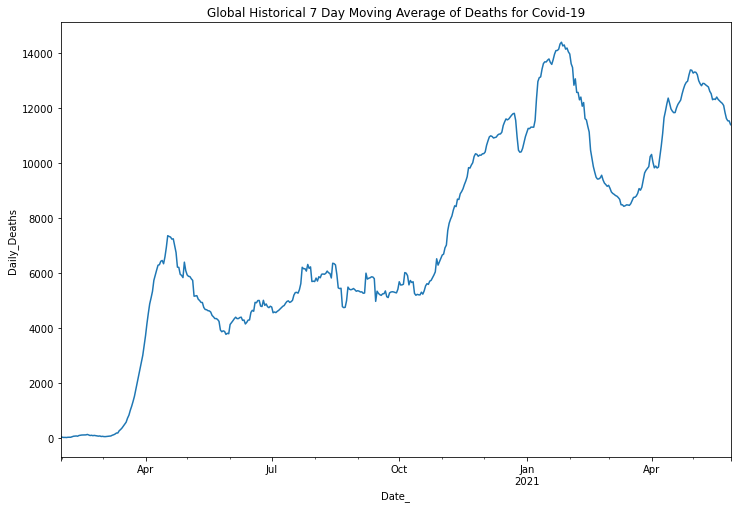

In [242]:
# Graph a 7 day rolling average rate
global_df['moving_average'] = global_df['Daily_Deaths'].rolling(7).mean()
global_df.dropna(inplace=True)
global_df['moving_average'] = global_df['moving_average'].astype(np.int)
title = 'Global Historical 7 Day Moving Average of Deaths for Covid-19'
plt.ylabel('Daily_Deaths')
plt.title(title)
global_df['moving_average'].plot();

Certainly a second wave and a VERY large one.

We can get the ARIMA model to grid search a solution to this.

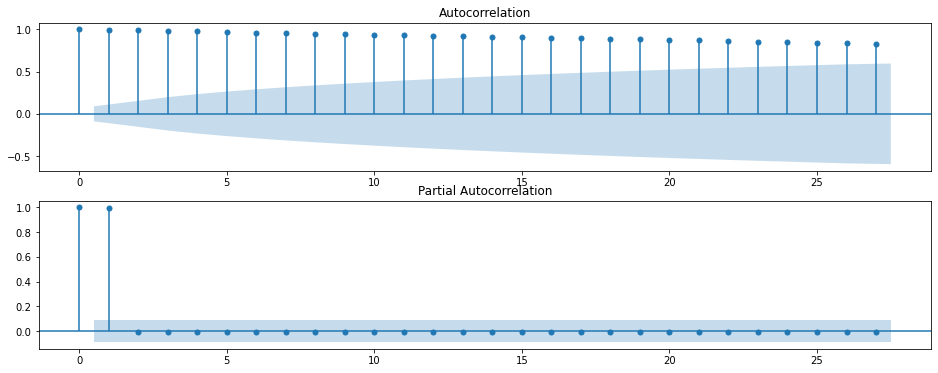

In [243]:
# ACF and PACF plots of the time series
series = global_df['Deaths']
plt.figure(figsize=(16,6))
plt.subplot(211)
plot_acf(series, ax=plt.gca())
plt.subplot(212)
plot_pacf(series, ax=plt.gca())
plt.show()

- The ACF shows significant lags to 10 time steps.
- The PACF shows significant lags to 2 time step.

This quick analysis suggests an ARIMA(10,2,1) on the raw data may be a good starting point. I ran it. It did not converge. So, lets evaluate a series of ARIMA models with a try and except block to avoid "LinAlgError: SVD did not converge"

In [244]:
def evaluate_arima_model(args):
    """evaluate an ARIMA model for a given order (p,d,q) and return RMSE and order"""
    
    # distribute args to appropriate variables
    test, history, order = args
    
    # make predictions
    predictions = []
    for t in range(len(test)):
        model = ARIMA(history, order=order)
        
        # fit model
        try:
            model_fit = model.fit(trend='nc', disp=0)
            yhat = model_fit.forecast()[0]
            predictions.append(yhat)
            history.append(test[t])
        except:
            continue
        
    # calculate out of sample error
    try:
        rmse = sqrt(mean_squared_error(test, predictions))
        print('RMSE is', round(rmse,3), 'with ARIMA of', order)
    
    except Exception as e:
        print(e)
        print('Model did not fit/predict so unable to compute RMSE for order', order)
        rmse = 999999
    
    return (rmse, order)

In [245]:
def evaluate_models(X, arima_list):
    """evaluate combinations of p, d and q values for an ARIMA model"""
    
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = list(train)
    rmse_list = []
    
    # Need to create the same number of inputs for each argument into the parallel function
    test_list = len(arima_list)*[X]
    history_list = len(arima_list)*[history]
    zip_list = list(zip(test_list, history_list, arima_list))
    
    # call function and run in parallel
    rmse_list = Parallel(n_jobs=-1, verbose=10)(delayed(evaluate_arima_model)(args) for args in zip_list)
                   
    # Sort the RMSEs
    rmse_list.sort(key=lambda tup: tup[0])
    
    # Sometimes, we do not have any ARIMA models that successfully fit and predict.
    try:
        print(f'\nBest RMSE Score is {round(rmse_list[0][0],3)} with ARIMA of {rmse_list[0][1]}')
    except:
        print('No ARIMA models fit and predicted successfully. Try different p,d,q parameters')
    
    return rmse_list

In [246]:
# load dataset
series = global_df['Deaths']

# evaluate parameters
p_values = range(1,8)
d_values = range(1,3)
q_values = range(0,3)

# Generate all different combinations of p, d and q triplets
arima_list = list(itertools.product(p_values, d_values, q_values))

rmse_list = evaluate_models(series.values, arima_list)
best_cfg = rmse_list[0][1]

# Create a df to display the rmse and pdq
rmse_order_df = pd.DataFrame({'RMSE': [x[0] for x in rmse_list], 'Order': [x[1] for x in rmse_list]})
rmse_order_df['RMSE'] = rmse_order_df['RMSE'].astype(np.int)
rmse_order_df.head(10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   59.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  32 out of  42 | elapsed:  3.3min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  37 out of  42 | elapsed:  3.8min remaining:   30.5s



Best RMSE Score is 46487.321 with ARIMA of (1, 1, 1)


[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:  4.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:  4.8min finished


,RMSE,Order
0,46487,"(1, 1, 1)"
1,46607,"(2, 1, 1)"
2,46907,"(1, 1, 0)"
3,46919,"(2, 1, 0)"
4,54690,"(3, 1, 0)"
5,59492,"(2, 1, 2)"
6,69551,"(1, 1, 2)"
7,75671,"(1, 2, 0)"
8,81467,"(2, 2, 0)"
9,999999,"(1, 2, 1)"


A RMSE of 999999 means that the fit/predict did not work for ARIMA. |

                 0
count   242.000000
mean    465.614525
std    2542.012852
min   -6626.706644
25%   -1210.593421
50%     454.869752
75%    2066.843787
max    7708.657193


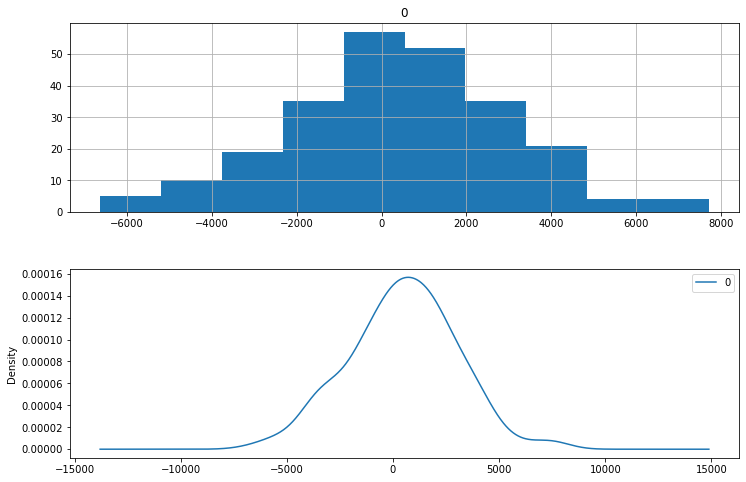


bias saved in bias for subsequent run is: 465.61452476014307 



In [247]:
# summarize residual errors for an ARIMA model

# load data
series = global_df['Deaths']

# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train]
predictions = []
for i in range(len(test)):
    
    # predict
    model = ARIMA(history, order=best_cfg)
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    
    # observation
    obs = test[i]
    history.append(obs)

# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)
print(residuals.describe())

# plot
plt.figure()
plt.subplot(211)
residuals.hist(ax=plt.gca())
plt.subplot(212)
residuals.plot(kind='kde', ax=plt.gca())
plt.show();

# Save mean for bias adjustment below
bias = residuals.describe()
bias = bias.iloc[1][0]
print('\nbias saved in bias for subsequent run is:', bias, '\n')

The histogram shows that the distribution has a right skew and that the mean is non-zero. This is perhaps a sign that the predictions are biased. The distribution of residual errors is also plotted. The graphs suggest a Gaussian-like distribution with a longer left tail. Lets see if the bias made any real difference.

RMSE: 2536.755
       Residual Statistics
count         2.420000e+02
mean         -3.415491e-11
std           2.542013e+03
min          -7.092321e+03
25%          -1.676208e+03
50%          -1.074477e+01
75%           1.601229e+03
max           7.243043e+03


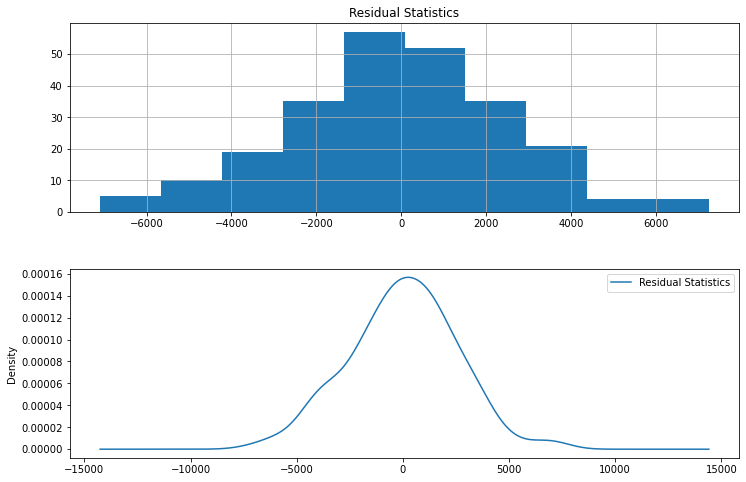

In [248]:
# summarize residual errors from bias corrected forecasts

# load data
series = global_df['Deaths']

# prepare data
X = series.values.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train]
predictions = list()
bias = bias # from above run
for i in range(len(test)):
    
    # predict
    model = ARIMA(history, order=best_cfg)
    model_fit = model.fit(trend='nc', disp=0)
    yhat = bias + float(model_fit.forecast()[0])
    predictions.append(yhat)
    
    # observation
    obs = test[i]
    history.append(obs)

# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

# summarize residual errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)
residuals = residuals.rename({0: 'Residual Statistics'}, axis=1)
print(residuals.describe())

# plot
# histogram
plt.figure()
plt.subplot(211)
residuals.hist(ax=plt.gca())

# density
plt.subplot(212)
residuals.plot(kind='kde', ax=plt.gca())
plt.show()

The bias had almost no effect on the RMSE. Considering that we will be looking at deaths in the range of 6 to 7 figures, not surprising that this made so little difference. 

The summary of the forecast residual errors shows that the mean was indeed moved to a value very close to zero. Finally, density plots of the residual error do show a small shift towards zero. Lets take a look at test vs predictions.

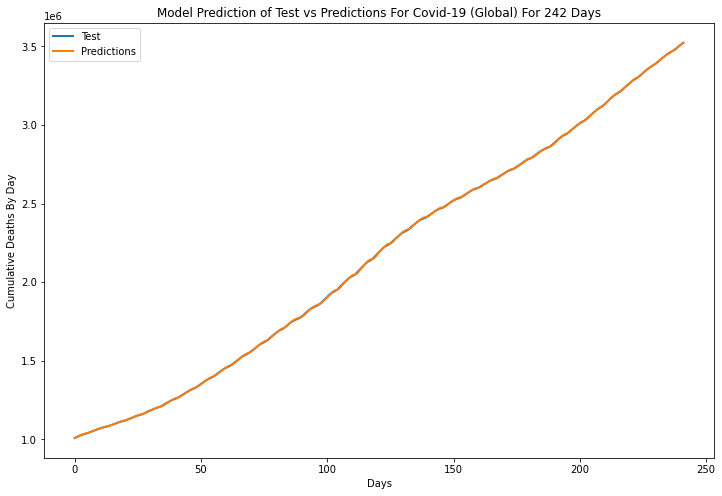

In [249]:
# Assemble title
title = ('Model Prediction of Test vs Predictions For Covid-19 ({}) For {} Days').format('Global', len(test))
plt.title(title)

# Create x and y axis labels
plt.xlabel('Days')
plt.ylabel('Cumulative Deaths By Day')

# Create plot
plt.plot(test, linewidth=2, label='Test')
plt.plot(predictions, linewidth=2, label='Predictions')
plt.legend()
plt.savefig(r'pics_final/test_vs_prediction.png');

Wow hard to believe that this is that accurate!

In [250]:
# save finalized model to file

def __getnewargs__(self):
    """# monkey patch around bug in ARIMA class"""
    return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))

ARIMA.__getnewargs__ = __getnewargs__

# load data
series = global_df['Deaths']

# prepare data
X = series.values.astype('float32')

# fit model
model = ARIMA(X, order=best_cfg)
model_fit = model.fit(trend='nc', disp=0)

# bias constant, could be calculated from in-sample mean residual
bias = bias

# save model
model_fit.save(r'data/model.pkl')
np.save(r'data/model_bias.npy', [bias])

In [251]:
# load finalized model
model_fit = ARIMAResults.load(r'data/model.pkl')
bias = np.load(r'data/model_bias.npy')

# Pick a future to predict. 0 means literally tomorrow.
yhat = bias + float(model_fit.forecast()[0])

In [252]:
# Format the float so that it is nicely readable
yhat = yhat.astype(int)
yhat = place_value(yhat[0])
print(f'Current global deaths are: {yhat}')

Current global deaths are: 3,534,996


This proves the model was saved,  loaded successfully, and performed a prediction. Lets forecast every day between now and March 31, 2020. We are also going to use ALL of the data since we have now put the model into "production".

In [253]:
global_df.shape

(484, 5)

In [254]:
# load dataset
series = global_df['Deaths']
X = series.values


# fit model
model = ARIMA(X, order=(best_cfg))
model_fit = model.fit(disp=0)

# forecast December 31, 2021
start = global_df.index[-1]
end = pd.to_datetime('2023-01-01', infer_datetime_format=True)
steps = end - start
steps = steps.days

# Fit the out of sample
forecast = model_fit.forecast(steps=steps)[0]

# Add the bias
predictions = []
for yhat in forecast:

    yhat = bias[0] + yhat
    predictions.append(yhat)
    
# Create a df for reporting
# Create a date_range index
start = global_df.index[-1]
end = start + timedelta(days=steps-1)

# Create the df
forecast_df = pd.DataFrame({'Deaths': predictions}, index=pd.date_range(start=start, end=end))

# Shift Deaths by one day to make it line up correctly with the date. 
forecast_df['Deaths'] = forecast_df['Deaths'].shift(1)
forecast_df = forecast_df[1:]
forecast_df.tail(1)

,Deaths
2022-12-31,7.779692e+06


That is a pretty big number. Lets check and see if it is reasonable. We will look at global_df and calculate its daily percent increase. Then we will look at forecast_df and see if it is comparable. 

In [255]:
# Take a copy of global_df
global_df_c = global_df.copy(deep=True)

# Drop the extra columns in global_df_c compared to report_df
global_df_c = global_df_c[['Deaths']]

# Create the extra columns
global_df_c['Increase'] = global_df_c['Deaths'] - global_df_c['Deaths'].shift(1)
global_df_c['Percent_Increase'] = (global_df_c['Increase'] / global_df_c['Deaths']) * 100
global_df_c['Percent_Increase'] = round(global_df_c['Percent_Increase'], 2)
global_df_c['Deaths'] = global_df_c['Deaths'].astype(np.int)

# Look at it
global_df_c.tail()

,Deaths,Increase,Percent_Increase
Date_,,,
2021-05-24,3473036,8824.0,0.25
2021-05-25,3485788,12752.0,0.37
2021-05-26,3498544,12756.0,0.36
2021-05-27,3511297,12753.0,0.36
2021-05-28,3523117,11820.0,0.34


In [256]:
# Look at daily percent increase for first 5 days
forecast_df['Increase'] = forecast_df['Deaths'] - forecast_df['Deaths'].shift(1)
forecast_df['Percent_Increase'] = (forecast_df['Increase'] / forecast_df['Deaths']) * 100
forecast_df['Percent_Increase'] = round(forecast_df['Percent_Increase'] ,2)
forecast_df['Deaths'] = forecast_df['Deaths'].astype(np.int)
forecast_df.head()

,Deaths,Increase,Percent_Increase
2021-05-29,3534771,NaN,NaN
2021-05-30,3545464,10692.792921,0.30
2021-05-31,3555723,10259.437176,0.29
2021-06-01,3565604,9880.778908,0.28
2021-06-02,3575154,9549.914286,0.27


In [257]:
print('These means all have to do with the day to day percentage increase.\n')
print(f'Last 14 days actual data mean is: {round(global_df_c.Percent_Increase.iloc[-14:].mean(), 2)}')
print(f'First 14 days forecast mean is: {round(forecast_df.Percent_Increase.iloc[:14].mean(), 2)}')
print(f'Actual data mean is: {round(global_df_c.Percent_Increase.mean(), 2)}')
print(f'Forecast mean is: {round(forecast_df.Percent_Increase.mean(), 2)}')

These means all have to do with the day to day percentage increase.

Last 14 days actual data mean is: 0.34
First 14 days forecast mean is: 0.25
Actual data mean is: 1.8
Forecast mean is: 0.14


If anything the ARIMA model is being MORE conservative than the data would suggest. 

In [258]:
predicted = place_value(int(forecast_df["Deaths"].iloc[-1]))
forecast_date = forecast_df.index[-1].strftime('%Y-%m-%d')
print(f'The prediction is for {predicted} cumulative deaths to occur by {forecast_date}')

The prediction is for 7,779,692 cumulative deaths to occur by 2022-12-31


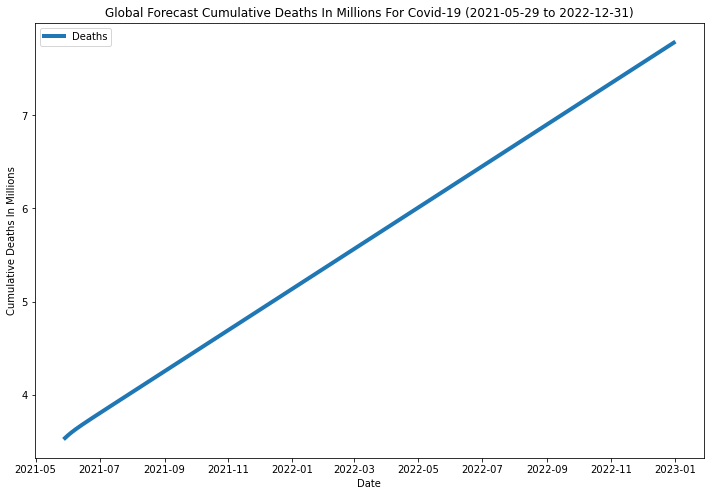

In [259]:
# Lets visualize that.
predict_deaths(forecast_df, 'Global')

ARIMA thinks that this is going to keep on going. I can certainly see why. There is nothing in the dataset that says it will do anything other than what it is doing here, which is heading up and to the right very rapidly. 

<a id='a4'></a>
### Answer to Question 4

> I created an ARIMA model. This predicts ~ 2 million people will not make it to 2021. These numbers will change if you rerun the notebook with the most recent data. The model was incredibly accurate in its test vs prediction scores. I think this is because the math of a pandemic is so simple. It is easy for the model to learn it.

<a id='q5'></a>
### Question 5

The answer to Q1 above, provides a fair answer of who is doing better or worse managing the covid pandemic by country. However, it is still a little abstract (deaths per million). Lets put this in very personal terms. How many deaths are there being caused by political mismanagement.

Lets divide the 14 countries that met the median per capita income cutoff and the transparency international score into 3 parts. The top 3, middle 8, and bottom 3. Lets take the median deaths per million of the top 3 countries and apply it to the bottom 3. Then take a percentage and that gives you what is the percentage contribution of a lack of leadership to the death of a person in that country from covid. Multiply that by deaths and you have the number of unnecessary deaths. You also have a "percentage blame factor" called mismanagement. Remember we have controlled for money and honesty. It just comes down to leadership. 

In [260]:
# refresh our memory what does this df look like for this Q/A
q1_df.head()

,Date_,Alpha_3,Confirmed,Deaths,Country_Region,MPC_Inc,Pop2020,TI_2019,Confirmed_e6,Deaths_e6
83,2021-05-28,NZL,2670.0,26.0,New Zealand,12147,4822233,87,553.685398,5.391693
5,2021-05-28,AUS,30083.0,910.0,Australia,15026,25499884,77,1179.730857,35.686437
81,2021-05-28,NOR,124410.0,783.0,Norway,19308,5421241,84,22948.620067,144.431875
37,2021-05-28,FIN,92244.0,948.0,Finland,15725,5540720,86,16648.377828,171.096897
30,2021-05-28,DNK,279139.0,2513.0,Denmark,18262,5792201,87,48192.215705,433.859253


In [261]:
# Make a copy
q5_df = q1_df.copy(deep=True)

In [262]:
# Lets reset the index. It is a little confusing right now.
q5_df.reset_index(drop=True, inplace=True)
q5_df.head()

,Date_,Alpha_3,Confirmed,Deaths,Country_Region,MPC_Inc,Pop2020,TI_2019,Confirmed_e6,Deaths_e6
0,2021-05-28,NZL,2670.0,26.0,New Zealand,12147,4822233,87,553.685398,5.391693
1,2021-05-28,AUS,30083.0,910.0,Australia,15026,25499884,77,1179.730857,35.686437
2,2021-05-28,NOR,124410.0,783.0,Norway,19308,5421241,84,22948.620067,144.431875
3,2021-05-28,FIN,92244.0,948.0,Finland,15725,5540720,86,16648.377828,171.096897
4,2021-05-28,DNK,279139.0,2513.0,Denmark,18262,5792201,87,48192.215705,433.859253


In [263]:
# Drop unneeded columns
q5_df = q5_df[['Date_', 'Alpha_3', 'Country_Region', 'Deaths', 'Deaths_e6']]
q5_df.head()

,Date_,Alpha_3,Country_Region,Deaths,Deaths_e6
0,2021-05-28,NZL,New Zealand,26.0,5.391693
1,2021-05-28,AUS,Australia,910.0,35.686437
2,2021-05-28,NOR,Norway,783.0,144.431875
3,2021-05-28,FIN,Finland,948.0,171.096897
4,2021-05-28,DNK,Denmark,2513.0,433.859253


In [264]:
# Get the median for the top 3 (Deaths_e6)
top_median = q5_df.iloc[:3,].median()[-1]
top_median

35.686436848104876

In [265]:
# Look at the bottom 3
q5_df.tail(3)

,Date_,Alpha_3,Country_Region,Deaths,Deaths_e6
11,2021-05-28,FRA,France,109452.0,1676.821092
12,2021-05-28,USA,United States,593963.0,1794.435779
13,2021-05-28,GBR,United Kingdom,128030.0,1885.955562


In [266]:
# Get the median for the bottom 3 (Deaths_e6)
bottom_median = q5_df.iloc[-3:,].median()[-1]
bottom_median

1794.435779307399

In [267]:
# What is the ratio between these 2
ratio = top_median / bottom_median
ratio

0.019887274462326437

In [268]:
# Percentage assignment to political leadership
mismanagement = round((1 - ratio),4)
print(f'{mismanagement}')

0.9801


In [269]:
q5_bottom = q5_df.tail(3)
q5_bottom

,Date_,Alpha_3,Country_Region,Deaths,Deaths_e6
11,2021-05-28,FRA,France,109452.0,1676.821092
12,2021-05-28,USA,United States,593963.0,1794.435779
13,2021-05-28,GBR,United Kingdom,128030.0,1885.955562


In [270]:
# Deaths due to political mismanagement
q5_bottom['Avoidable'] = (q5_bottom['Deaths'] * mismanagement).astype(np.int)
q5_bottom

,Date_,Alpha_3,Country_Region,Deaths,Deaths_e6,Avoidable
11,2021-05-28,FRA,France,109452.0,1676.821092,107273
12,2021-05-28,USA,United States,593963.0,1794.435779,582143
13,2021-05-28,GBR,United Kingdom,128030.0,1885.955562,125482


In [271]:
print('The Buck Stops At The Leadership\n')
for idx in range(3):
    print('{} has {} avoidable deaths'.format(
        q5_bottom['Country_Region'].iloc[idx],
        place_value(q5_bottom['Avoidable'].iloc[idx]))) 

The Buck Stops At The Leadership

France has 107,273 avoidable deaths
United States has 582,143 avoidable deaths
United Kingdom has 125,482 avoidable deaths


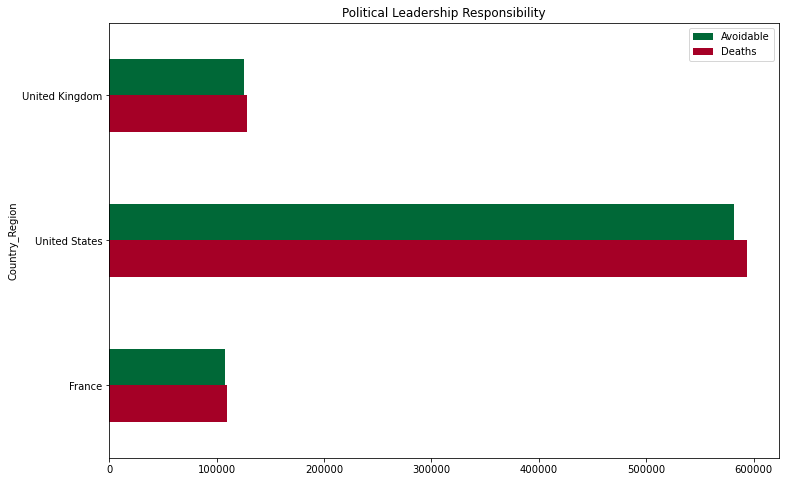

In [272]:
q5_bottom.plot.barh(x = 'Country_Region', 
                    y = ['Deaths', 'Avoidable'],
                    title = 'Political Leadership Responsibility',
                    legend = 'reverse',
                    colormap = 'RdYlGn');

<a id='a5'></a>
### Answer to Question 5

If you live in these bottom 3 countries this means if that country had managed the pandemic as well as the median of the top 3, this many people would have lived. 98% of the problem lies with leadership (or lack of).

<a id='conclusions'></a>
# Results and Conclusions

> We answered 4 questions in this notebook. Please click on these links to look at those answers.
<li style="margin-left: 40px"><a href="#a1">Answer To Q1</a></li>
<li style="margin-left: 40px"><a href="#a2">Answer To Q2</a></li>
<li style="margin-left: 40px"><a href="#a3">Answer To Q3</a></li>
<li style="margin-left: 40px"><a href="#a4">Answer To Q4</a></li>
<li style="margin-left: 40px"><a href="#a5">Answer To Q5</a></li>

> 24 of 28 countries (that met the cutoffs) have a flattening of the curve presently. That is VERY encouraging.

> It is surprising to see rich countries struggle with this virus. There is a saying that democracies get the type of leadership that they deserve. Hopefully this is a wake up call that electing incompetent politicians with massive character flaws to the highest office in the land can and does cause death. This time those deaths are being counted. They are not hidden in Syria, Afghanistan, etc. They are right in the home countries that have weak leadership.

> Including the Median Per Capita Income and the Transparency International score was helpful in terms of creating cutoffs that made sense.  

> Leadership matters. 100s of thousands of people are dying unnecessarily.

> One sobering thought here is that there are 203 unique Alpha_3 codes in this dataset. That corresponds to 203 Country_Regions. We are only looking at 28 of them. This is because of the concern over the honesty of the data. In otherwords the challenge that we are looking at here is only the tip of the iceberg.

<a id='limitations'></a>
# Limitations

Generally speaking I believe the reporting on the John Hopkins data is extremely suspect. This is due to political and on the ground issues. Politicians do not want to be accused of doing less than a great job, especially when it is obvious they are doing anything but a great job. Many countries simply do not have the infrastructure, systems, etc. to care for the sick and to report. People are dying and they are not reporting those statistics. Cases are happening and they do not have testing. It is likely that the only reasonable data that you will get and it will be still be grossly under reported in terms of actual cases will be from the western democracies. However, the Transparency International score I have included gives me some confidence for all of the findings in this notebook. 

<a id='deploy'></a>
# Deploy

> Update the John Hopkins, Covid-19 data https://github.com/CSSEGISandData/COVID-19 by refreshing your local copy of the GitHub repository. The ARIMA model has been hyper parameter tuned, stored on disk and is ready to go. There is a forecasting module included for this dataset that can be ran at any time. It remains to be seen whether or not its predictions will be accurate. For additonal information please refer to the ReadMe.